# Similar to Baseline Learning, we start off by training model on debugging dataset in the same manner described in the Baseline Learning notebook

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader



# Setting up the datasets, both main and debugging

In [ ]:
debugging_dataset = pd.read_pickle('debugging_dataset.pkl')
working_dataset = pd.read_pickle('working_dataset.pkl')

# Grade columns (GT)
grade_columns = ['A+', 'A', 'A-', 'B+', 'B', 'B-', 'C+', 'C', 'C-', 'D+', 'D', 'D-', 'F', 'W']

# Categorical columns (features)
categorical_columns = ['Year', 'Term', 'Subject', 'Sched Type', 'Number', 'Course Title']


In [ ]:
import os

# 文件路径
debugging_dataset_path = 'debugging_dataset.pkl'
working_dataset_path = 'working_dataset.pkl'

# 检查文件是否存在并获取大小
def get_file_size(file_path):
    if os.path.exists(file_path):
        file_size = os.path.getsize(file_path)  # 文件大小（字节）
        file_size_mb = file_size / (1024 * 1024)  # 转换为 MB
        return f"{file_path}: {file_size_mb:.2f} MB"
    else:
        return f"{file_path} 不存在。"

# 输出文件大小
print(get_file_size(debugging_dataset_path))
print(get_file_size(working_dataset_path))


debugging_dataset.pkl: 0.47 MB
working_dataset.pkl: 9.46 MB


# Dataloader Definition and initialization

## We will one-hot encode each category first, computing required embedding space for each category.

In [ ]:
max_categories = {
    col: max(debugging_dataset[col].nunique(), working_dataset[col].nunique())
    for col in categorical_columns
}
print("Maximum categories for each column:", max_categories)


Maximum categories for each column: {'Year': 13, 'Term': 4, 'Subject': 172, 'Sched Type': 18, 'Number': 553, 'Course Title': 5591}


split manner is as follow: 0.75: 0.15: 0.15 for train, val, test

In [ ]:
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

debug_train, debug_temp = train_test_split(debugging_dataset, test_size=(1 - train_ratio), random_state=42)
debug_val, debug_test = train_test_split(debug_temp, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)

work_train, work_temp = train_test_split(working_dataset, test_size=(1 - train_ratio), random_state=42)
work_val, work_test = train_test_split(work_temp, test_size=(test_ratio / (val_ratio + test_ratio)), random_state=42)

print(f"Debugging Train: {len(debug_train)}, Val: {len(debug_val)}, Test: {len(debug_test)}")
print(f"Working Train: {len(work_train)}, Val: {len(work_val)}, Test: {len(work_test)}")


Debugging Train: 2065, Val: 443, Test: 443
Working Train: 41311, Val: 8852, Test: 8853


In [ ]:
def one_hot_encode_fixed(dataframe, column, max_categories):
    encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    one_hot = encoder.fit_transform(dataframe[[column]])

    padded = np.zeros((len(dataframe), max_categories))
    padded[:, :one_hot.shape[1]] = one_hot
    return padded

def encode_categorical_features(dataframe, categorical_columns, max_categories):
    one_hot_encoded = {
        col: one_hot_encode_fixed(dataframe, col, max_categories[col])
        for col in categorical_columns
    }
    return one_hot_encoded


In [ ]:
debug_train_encoded = encode_categorical_features(debug_train, categorical_columns, max_categories)
debug_val_encoded = encode_categorical_features(debug_val, categorical_columns, max_categories)
debug_test_encoded = encode_categorical_features(debug_test, categorical_columns, max_categories)

work_train_encoded = encode_categorical_features(work_train, categorical_columns, max_categories)
work_val_encoded = encode_categorical_features(work_val, categorical_columns, max_categories)
work_test_encoded = encode_categorical_features(work_test, categorical_columns, max_categories)

for col in categorical_columns:
    print(f"{col} (Debug Train): {debug_train_encoded[col].shape}")
    print(f"{col} (Work Train): {work_train_encoded[col].shape}")


Year (Debug Train): (2065, 13)
Year (Work Train): (41311, 13)
Term (Debug Train): (2065, 4)
Term (Work Train): (41311, 4)
Subject (Debug Train): (2065, 172)
Subject (Work Train): (41311, 172)
Sched Type (Debug Train): (2065, 18)
Sched Type (Work Train): (41311, 18)
Number (Debug Train): (2065, 553)
Number (Work Train): (41311, 553)
Course Title (Debug Train): (2065, 5591)
Course Title (Work Train): (41311, 5591)


## Build the dataloader and initliaize it, making sure to shuffle the training sets to avoid overfitting

In [ ]:
class GradeDataset(Dataset):
    def __init__(self, encoded_features, grade_columns, targets_dataframe):
        self.encoded_features = {col: torch.tensor(encoded_features[col], dtype=torch.float32) for col in encoded_features}
        self.targets = torch.tensor(targets_dataframe[grade_columns].values, dtype=torch.float32)

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        # we further drop the feature 'Course Title'
        features = {col: self.encoded_features[col][idx] for col in self.encoded_features if col != 'Course Title'}
        # features = {col: self.encoded_features[col][idx] for col in self.encoded_features}
        return features, self.targets[idx]


In [ ]:
debug_train_dataset = GradeDataset(debug_train_encoded, grade_columns, debug_train)
debug_val_dataset = GradeDataset(debug_val_encoded, grade_columns, debug_val)
debug_test_dataset = GradeDataset(debug_test_encoded, grade_columns, debug_test)

work_train_dataset = GradeDataset(work_train_encoded, grade_columns, work_train)
work_val_dataset = GradeDataset(work_val_encoded, grade_columns, work_val)
work_test_dataset = GradeDataset(work_test_encoded, grade_columns, work_test)

debug_train_loader = DataLoader(debug_train_dataset, batch_size=64, shuffle=True)
debug_val_loader = DataLoader(debug_val_dataset, batch_size=64, shuffle=False)
debug_test_loader = DataLoader(debug_test_dataset, batch_size=64, shuffle=False)

work_train_loader = DataLoader(work_train_dataset, batch_size=64, shuffle=True)
work_val_loader = DataLoader(work_val_dataset, batch_size=64, shuffle=False)
work_test_loader = DataLoader(work_test_dataset, batch_size=64, shuffle=False)



In [ ]:
# check the features in the datset
for features, targets in debug_train_loader:
    print(f"Features keys and shapes: {features.keys()}")
    print(f"Targets shape: {targets.shape}")
    break
for features, targets in work_train_loader:
    print(f"Features keys and shapes: {features.keys()}")
    print(f"Targets shape: {targets.shape}")
    break

Features keys and shapes: dict_keys(['Year', 'Term', 'Subject', 'Sched Type', 'Number'])
Targets shape: torch.Size([64, 14])
Features keys and shapes: dict_keys(['Year', 'Term', 'Subject', 'Sched Type', 'Number'])
Targets shape: torch.Size([64, 14])


# KAN


In [ ]:
pip install git+https://github.com/KindXiaoming/pykan.git


  Cloning https://github.com/KindXiaoming/pykan.git to /tmp/pip-req-build-_6xmk0b0
  Running command git clone --filter=blob:none --quiet https://github.com/KindXiaoming/pykan.git /tmp/pip-req-build-_6xmk0b0
  Resolved https://github.com/KindXiaoming/pykan.git to commit f871c26d4df788ec1ba309c2c9c1803d82606b06
  Preparing metadata (setup.py) ... done
  Created wheel for pykan: filename=pykan-0.2.8-py3-none-any.whl size=78208 sha256=7906f1bd7c093a44f45a7871edfc49ca13dfae0d1c18ab02319aec851a71b150
  Stored in directory: /tmp/pip-ephem-wheel-cache-wpfp_lii/wheels/47/ca/5a/98124e020f3119f51c17f78738c621c140b7aa803b0feda76e
Successfully built pykan


In [ ]:
from google.colab import files
uploaded = files.upload()


KeyboardInterrupt: 

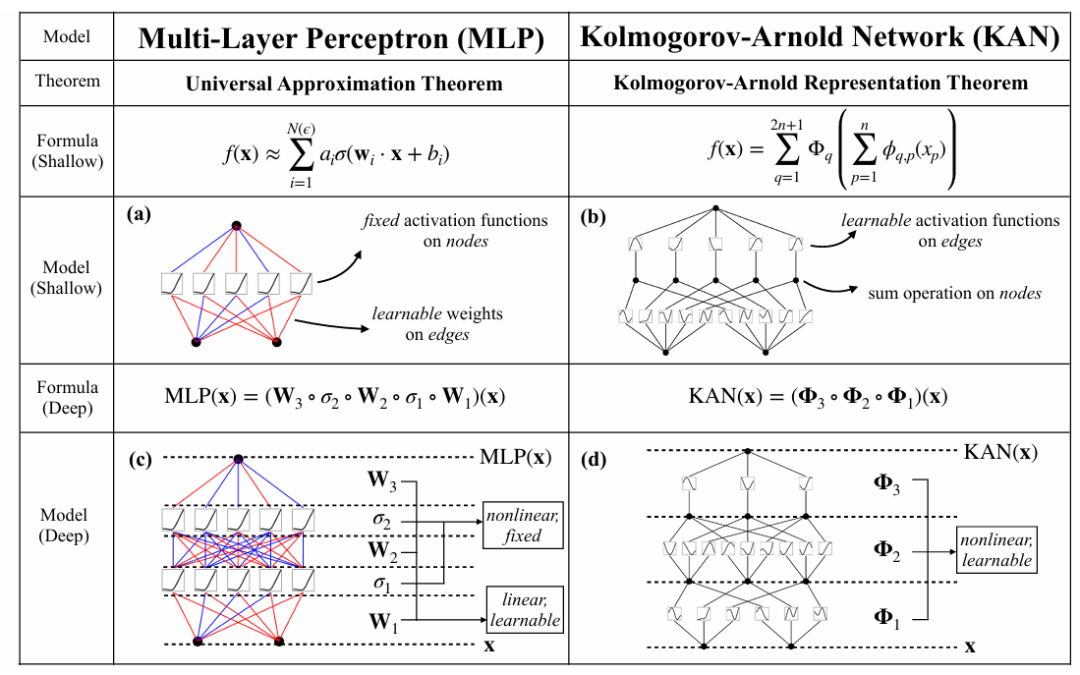

In [ ]:
from IPython.display import Image
Image(filename='kan.png')


In [ ]:
from kan import create_dataset
print("KAN library is installed and ready to use!")


KAN library is installed and ready to use!


In [ ]:
print(type(debug_train_encoded))
n_var = len(debug_train_encoded)
print(f"Number of features: {n_var}")


<class 'dict'>
Number of features: 6


In [ ]:
def dataloader_to_kan_dataset(dataloader, grade_columns, device):
    """
    Extracts data from the DataLoader and converts it into a format suitable for KAN.

    Returns:
    - kan_datasets: A dictionary where keys are grade column names, and values are dictionaries
      containing KAN dataset, feature count, and target values.
    """
    kan_datasets = {}

    for grade in grade_columns:
        features_list = []
        targets_list = []

        # Iterate over the batches in the DataLoader
        for batch in dataloader:
            features, targets = batch

            # Extract feature tensors and stack them by columns
            feature_tensor = torch.cat([features[col] for col in features], dim=1).to(device)
            features_list.append(feature_tensor)
            targets_list.append(targets[:, grade_columns.index(grade)])

        # Combine all batches
        feature_matrix = torch.cat(features_list, dim=0).to(device)
        targets = torch.cat(targets_list, dim=0).to(device)

        # Create the KAN dataset
        kan_dataset = create_dataset(lambda x: targets, n_var=feature_matrix.shape[1], device=device)

        # Store the KAN dataset and metadata (feature count and targets)
        kan_datasets[grade] = {
            "dataset": kan_dataset,
            "n_var": feature_matrix.shape[1],
            "targets": targets,
        }

    return kan_datasets


In [ ]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())


2.5.1+cu121
True


In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
work_train_kan_datasets = dataloader_to_kan_dataset(work_train_loader, grade_columns, device)
work_val_kan_datasets = dataloader_to_kan_dataset(work_val_loader, grade_columns, device)

for grade in grade_columns:
    kan_info = work_train_kan_datasets[grade]
    print(f"Grade: {grade}, Number of Variables: {kan_info['n_var']}, Target Shape: {kan_info['targets'].shape}")

Using device: cuda
Grade: A+, Number of Variables: 760, Target Shape: torch.Size([41311])
Grade: A, Number of Variables: 760, Target Shape: torch.Size([41311])
Grade: A-, Number of Variables: 760, Target Shape: torch.Size([41311])
Grade: B+, Number of Variables: 760, Target Shape: torch.Size([41311])
Grade: B, Number of Variables: 760, Target Shape: torch.Size([41311])
Grade: B-, Number of Variables: 760, Target Shape: torch.Size([41311])
Grade: C+, Number of Variables: 760, Target Shape: torch.Size([41311])
Grade: C, Number of Variables: 760, Target Shape: torch.Size([41311])
Grade: C-, Number of Variables: 760, Target Shape: torch.Size([41311])
Grade: D+, Number of Variables: 760, Target Shape: torch.Size([41311])
Grade: D, Number of Variables: 760, Target Shape: torch.Size([41311])
Grade: D-, Number of Variables: 760, Target Shape: torch.Size([41311])
Grade: F, Number of Variables: 760, Target Shape: torch.Size([41311])
Grade: W, Number of Variables: 760, Target Shape: torch.Size([4

Training KAN for grade: A+
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.79e-01 | test_loss: 1.79e-01 | reg: 1.57e+01 | : 100%|█| 1/1 [00:01<00:00,  1.72s/it


saving model version 0.1


| train_loss: 1.79e-01 | test_loss: 1.79e-01 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.2


| train_loss: 1.79e-01 | test_loss: 1.79e-01 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.60s/it


saving model version 0.3


| train_loss: 1.79e-01 | test_loss: 1.79e-01 | reg: 1.52e+01 | : 100%|█| 1/1 [00:02<00:00,  2.73s/it


saving model version 0.4


| train_loss: 1.79e-01 | test_loss: 1.79e-01 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.98s/it


saving model version 0.5


| train_loss: 1.79e-01 | test_loss: 1.79e-01 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.6


| train_loss: 1.79e-01 | test_loss: 1.79e-01 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.57s/it


saving model version 0.7


| train_loss: 1.79e-01 | test_loss: 1.79e-01 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.8


| train_loss: 1.79e-01 | test_loss: 1.79e-01 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.9


| train_loss: 1.79e-01 | test_loss: 1.79e-01 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.75s/it


saving model version 0.10


| train_loss: 1.79e-01 | test_loss: 1.79e-01 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.11


| train_loss: 1.79e-01 | test_loss: 1.79e-01 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.62s/it


saving model version 0.12


| train_loss: 1.79e-01 | test_loss: 1.79e-01 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.57s/it


saving model version 0.13
Early stopping triggered for grid 3 at step 12
Training KAN for grade: A
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.30e-01 | test_loss: 2.31e-01 | reg: 1.48e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.1


| train_loss: 2.30e-01 | test_loss: 2.30e-01 | reg: 1.38e+01 | : 100%|█| 1/1 [00:01<00:00,  1.56s/it


saving model version 0.2


| train_loss: 2.29e-01 | test_loss: 2.29e-01 | reg: 1.36e+01 | : 100%|█| 1/1 [00:01<00:00,  1.78s/it


saving model version 0.3


| train_loss: 2.29e-01 | test_loss: 2.29e-01 | reg: 1.35e+01 | : 100%|█| 1/1 [00:01<00:00,  1.69s/it


saving model version 0.4


| train_loss: 2.29e-01 | test_loss: 2.29e-01 | reg: 1.35e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.5


| train_loss: 2.29e-01 | test_loss: 2.29e-01 | reg: 1.35e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.6


| train_loss: 2.29e-01 | test_loss: 2.29e-01 | reg: 1.35e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.7


| train_loss: 2.29e-01 | test_loss: 2.29e-01 | reg: 1.35e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.8


| train_loss: 2.29e-01 | test_loss: 2.29e-01 | reg: 1.35e+01 | : 100%|█| 1/1 [00:01<00:00,  1.66s/it


saving model version 0.9


| train_loss: 2.29e-01 | test_loss: 2.29e-01 | reg: 1.34e+01 | : 100%|█| 1/1 [00:01<00:00,  1.80s/it


saving model version 0.10


| train_loss: 2.29e-01 | test_loss: 2.29e-01 | reg: 1.34e+01 | : 100%|█| 1/1 [00:01<00:00,  1.61s/it


saving model version 0.11


| train_loss: 2.29e-01 | test_loss: 2.29e-01 | reg: 1.34e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.12


| train_loss: 2.29e-01 | test_loss: 2.29e-01 | reg: 1.34e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.13


| train_loss: 2.29e-01 | test_loss: 2.29e-01 | reg: 1.34e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.14


| train_loss: 2.29e-01 | test_loss: 2.29e-01 | reg: 1.34e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.15


| train_loss: 2.29e-01 | test_loss: 2.29e-01 | reg: 1.34e+01 | : 100%|█| 1/1 [00:01<00:00,  1.76s/it


saving model version 0.16


| train_loss: 2.29e-01 | test_loss: 2.29e-01 | reg: 1.33e+01 | : 100%|█| 1/1 [00:01<00:00,  1.67s/it


saving model version 0.17


| train_loss: 2.29e-01 | test_loss: 2.29e-01 | reg: 1.32e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.18


| train_loss: 2.29e-01 | test_loss: 2.29e-01 | reg: 1.31e+01 | : 100%|█| 1/1 [00:01<00:00,  1.60s/it


saving model version 0.19


| train_loss: 2.29e-01 | test_loss: 2.29e-01 | reg: 1.31e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.20


| train_loss: 2.29e-01 | test_loss: 2.29e-01 | reg: 1.31e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.21


| train_loss: 2.29e-01 | test_loss: 2.29e-01 | reg: 1.31e+01 | : 100%|█| 1/1 [00:01<00:00,  1.68s/it


saving model version 0.22


| train_loss: 2.29e-01 | test_loss: 2.29e-01 | reg: 1.31e+01 | : 100%|█| 1/1 [00:01<00:00,  1.80s/it


saving model version 0.23


| train_loss: 2.29e-01 | test_loss: 2.29e-01 | reg: 1.31e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.24


| train_loss: 2.29e-01 | test_loss: 2.29e-01 | reg: 1.31e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.25


| train_loss: 2.29e-01 | test_loss: 2.29e-01 | reg: 1.31e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.26


| train_loss: 2.29e-01 | test_loss: 2.29e-01 | reg: 1.31e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.27


| train_loss: 2.29e-01 | test_loss: 2.29e-01 | reg: 1.31e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.28


| train_loss: 2.29e-01 | test_loss: 2.29e-01 | reg: 1.31e+01 | : 100%|█| 1/1 [00:01<00:00,  1.77s/it


saving model version 0.29


| train_loss: 2.29e-01 | test_loss: 2.29e-01 | reg: 1.31e+01 | : 100%|█| 1/1 [00:01<00:00,  1.65s/it


saving model version 0.30


| train_loss: 2.29e-01 | test_loss: 2.29e-01 | reg: 1.31e+01 | : 100%|█| 1/1 [00:01<00:00,  1.61s/it


saving model version 0.31


| train_loss: 2.29e-01 | test_loss: 2.29e-01 | reg: 1.30e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.32


| train_loss: 2.29e-01 | test_loss: 2.29e-01 | reg: 1.30e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.33


| train_loss: 2.29e-01 | test_loss: 2.29e-01 | reg: 1.30e+01 | : 100%|█| 1/1 [00:01<00:00,  1.61s/it


saving model version 0.34
Early stopping triggered for grid 3 at step 33
Training KAN for grade: A-
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.11e-01 | test_loss: 1.11e-01 | reg: 1.58e+01 | : 100%|█| 1/1 [00:01<00:00,  1.70s/it


saving model version 0.1


| train_loss: 1.11e-01 | test_loss: 1.10e-01 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.77s/it


saving model version 0.2


| train_loss: 1.11e-01 | test_loss: 1.11e-01 | reg: 1.51e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.3


| train_loss: 1.11e-01 | test_loss: 1.11e-01 | reg: 1.51e+01 | : 100%|█| 1/1 [00:01<00:00,  1.60s/it


saving model version 0.4


| train_loss: 1.11e-01 | test_loss: 1.11e-01 | reg: 1.51e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.5


| train_loss: 1.11e-01 | test_loss: 1.11e-01 | reg: 1.50e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.6


| train_loss: 1.11e-01 | test_loss: 1.11e-01 | reg: 1.50e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.7


| train_loss: 1.11e-01 | test_loss: 1.11e-01 | reg: 1.50e+01 | : 100%|█| 1/1 [00:01<00:00,  1.77s/it


saving model version 0.8


| train_loss: 1.11e-01 | test_loss: 1.11e-01 | reg: 1.50e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.9


| train_loss: 1.11e-01 | test_loss: 1.11e-01 | reg: 1.50e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.10


| train_loss: 1.11e-01 | test_loss: 1.11e-01 | reg: 1.50e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.11


| train_loss: 1.11e-01 | test_loss: 1.11e-01 | reg: 1.50e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.12


| train_loss: 1.11e-01 | test_loss: 1.11e-01 | reg: 1.50e+01 | : 100%|█| 1/1 [00:01<00:00,  1.61s/it


saving model version 0.13


| train_loss: 1.11e-01 | test_loss: 1.11e-01 | reg: 1.50e+01 | : 100%|█| 1/1 [00:01<00:00,  1.74s/it


saving model version 0.14
Early stopping triggered for grid 3 at step 13
Training KAN for grade: B+
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 9.40e-02 | test_loss: 9.41e-02 | reg: 1.57e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.1


| train_loss: 9.40e-02 | test_loss: 9.40e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.2


| train_loss: 9.40e-02 | test_loss: 9.40e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.3


| train_loss: 9.40e-02 | test_loss: 9.40e-02 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.4


| train_loss: 9.40e-02 | test_loss: 9.40e-02 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.5


| train_loss: 9.40e-02 | test_loss: 9.40e-02 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.74s/it


saving model version 0.6


| train_loss: 9.40e-02 | test_loss: 9.40e-02 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.80s/it


saving model version 0.7


| train_loss: 9.40e-02 | test_loss: 9.40e-02 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.60s/it


saving model version 0.8


| train_loss: 9.40e-02 | test_loss: 9.40e-02 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.60s/it


saving model version 0.9


| train_loss: 9.40e-02 | test_loss: 9.40e-02 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.10


| train_loss: 9.40e-02 | test_loss: 9.40e-02 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.61s/it


saving model version 0.11


| train_loss: 9.40e-02 | test_loss: 9.40e-02 | reg: 1.51e+01 | : 100%|█| 1/1 [00:01<00:00,  1.62s/it


saving model version 0.12


| train_loss: 9.40e-02 | test_loss: 9.40e-02 | reg: 1.51e+01 | : 100%|█| 1/1 [00:01<00:00,  1.80s/it


saving model version 0.13


| train_loss: 9.40e-02 | test_loss: 9.40e-02 | reg: 1.51e+01 | : 100%|█| 1/1 [00:01<00:00,  1.60s/it


saving model version 0.14


| train_loss: 9.40e-02 | test_loss: 9.40e-02 | reg: 1.51e+01 | : 100%|█| 1/1 [00:01<00:00,  1.62s/it


saving model version 0.15


| train_loss: 9.40e-02 | test_loss: 9.40e-02 | reg: 1.51e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.16


| train_loss: 9.40e-02 | test_loss: 9.40e-02 | reg: 1.51e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.17


| train_loss: 9.37e-02 | test_loss: 9.37e-02 | reg: 1.51e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.18


| train_loss: 9.37e-02 | test_loss: 9.37e-02 | reg: 1.51e+01 | : 100%|█| 1/1 [00:01<00:00,  1.74s/it


saving model version 0.19


| train_loss: 9.06e-02 | test_loss: 9.05e-02 | reg: 1.46e+01 | : 100%|█| 1/1 [00:01<00:00,  1.73s/it


saving model version 0.20


| train_loss: 9.06e-02 | test_loss: 9.06e-02 | reg: 1.37e+01 | : 100%|█| 1/1 [00:01<00:00,  1.51s/it


saving model version 0.21


| train_loss: 9.08e-02 | test_loss: 9.08e-02 | reg: 1.35e+01 | : 100%|█| 1/1 [00:01<00:00,  1.53s/it


saving model version 0.22


| train_loss: 9.08e-02 | test_loss: 9.07e-02 | reg: 1.34e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.23


| train_loss: 9.08e-02 | test_loss: 9.08e-02 | reg: 1.34e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.24


| train_loss: 9.08e-02 | test_loss: 9.07e-02 | reg: 1.33e+01 | : 100%|█| 1/1 [00:01<00:00,  1.61s/it


saving model version 0.25


| train_loss: 9.08e-02 | test_loss: 9.08e-02 | reg: 1.33e+01 | : 100%|█| 1/1 [00:01<00:00,  1.79s/it


saving model version 0.26


| train_loss: 9.08e-02 | test_loss: 9.07e-02 | reg: 1.33e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.27


| train_loss: 9.08e-02 | test_loss: 9.08e-02 | reg: 1.33e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.28


| train_loss: 9.08e-02 | test_loss: 9.07e-02 | reg: 1.33e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.29


| train_loss: 9.08e-02 | test_loss: 9.08e-02 | reg: 1.33e+01 | : 100%|█| 1/1 [00:01<00:00,  1.60s/it


saving model version 0.30


| train_loss: 9.08e-02 | test_loss: 9.07e-02 | reg: 1.33e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.31


| train_loss: 9.08e-02 | test_loss: 9.07e-02 | reg: 1.33e+01 | : 100%|█| 1/1 [00:01<00:00,  1.73s/it


saving model version 0.32
Early stopping triggered for grid 3 at step 31
Training KAN for grade: B
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.06e-01 | test_loss: 1.06e-01 | reg: 1.57e+01 | : 100%|█| 1/1 [00:01<00:00,  1.60s/it


saving model version 0.1


| train_loss: 1.06e-01 | test_loss: 1.06e-01 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.2


| train_loss: 1.06e-01 | test_loss: 1.06e-01 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.3


| train_loss: 1.06e-01 | test_loss: 1.06e-01 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.4


| train_loss: 1.06e-01 | test_loss: 1.06e-01 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.5


| train_loss: 1.06e-01 | test_loss: 1.06e-01 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.74s/it


saving model version 0.6


| train_loss: 1.06e-01 | test_loss: 1.06e-01 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.74s/it


saving model version 0.7


| train_loss: 1.06e-01 | test_loss: 1.06e-01 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.8


| train_loss: 1.06e-01 | test_loss: 1.06e-01 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.9


| train_loss: 1.06e-01 | test_loss: 1.06e-01 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.10


| train_loss: 1.06e-01 | test_loss: 1.06e-01 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.11


| train_loss: 1.06e-01 | test_loss: 1.06e-01 | reg: 1.51e+01 | : 100%|█| 1/1 [00:01<00:00,  1.62s/it


saving model version 0.12


| train_loss: 1.04e-01 | test_loss: 1.04e-01 | reg: 1.50e+01 | : 100%|█| 1/1 [00:01<00:00,  1.76s/it


saving model version 0.13


| train_loss: 1.04e-01 | test_loss: 1.04e-01 | reg: 1.46e+01 | : 100%|█| 1/1 [00:01<00:00,  1.56s/it


saving model version 0.14


| train_loss: 1.04e-01 | test_loss: 1.04e-01 | reg: 1.45e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.15


| train_loss: 1.04e-01 | test_loss: 1.04e-01 | reg: 1.44e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.16


| train_loss: 1.04e-01 | test_loss: 1.04e-01 | reg: 1.43e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.17


| train_loss: 1.04e-01 | test_loss: 1.04e-01 | reg: 1.43e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.18


| train_loss: 1.04e-01 | test_loss: 1.04e-01 | reg: 1.43e+01 | : 100%|█| 1/1 [00:01<00:00,  1.74s/it


saving model version 0.19


| train_loss: 1.04e-01 | test_loss: 1.04e-01 | reg: 1.43e+01 | : 100%|█| 1/1 [00:01<00:00,  1.75s/it


saving model version 0.20


| train_loss: 1.04e-01 | test_loss: 1.04e-01 | reg: 1.43e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.21


| train_loss: 1.04e-01 | test_loss: 1.04e-01 | reg: 1.43e+01 | : 100%|█| 1/1 [00:01<00:00,  1.62s/it


saving model version 0.22


| train_loss: 1.04e-01 | test_loss: 1.04e-01 | reg: 1.42e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.23


| train_loss: 1.04e-01 | test_loss: 1.04e-01 | reg: 1.42e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.24


| train_loss: 1.04e-01 | test_loss: 1.04e-01 | reg: 1.42e+01 | : 100%|█| 1/1 [00:01<00:00,  1.65s/it


saving model version 0.25
Early stopping triggered for grid 3 at step 24
Training KAN for grade: B-
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.02e-02 | test_loss: 6.02e-02 | reg: 1.56e+01 | : 100%|█| 1/1 [00:01<00:00,  1.82s/it


saving model version 0.1


| train_loss: 6.02e-02 | test_loss: 6.02e-02 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.2


| train_loss: 6.01e-02 | test_loss: 6.01e-02 | reg: 1.51e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.3


| train_loss: 6.02e-02 | test_loss: 6.02e-02 | reg: 1.51e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.4


| train_loss: 6.02e-02 | test_loss: 6.02e-02 | reg: 1.51e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.5


| train_loss: 6.02e-02 | test_loss: 6.02e-02 | reg: 1.51e+01 | : 100%|█| 1/1 [00:01<00:00,  1.60s/it


saving model version 0.6


| train_loss: 6.02e-02 | test_loss: 6.02e-02 | reg: 1.51e+01 | : 100%|█| 1/1 [00:01<00:00,  1.77s/it


saving model version 0.7


| train_loss: 6.02e-02 | test_loss: 6.02e-02 | reg: 1.51e+01 | : 100%|█| 1/1 [00:01<00:00,  1.66s/it


saving model version 0.8


| train_loss: 6.02e-02 | test_loss: 6.02e-02 | reg: 1.50e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.9


| train_loss: 6.02e-02 | test_loss: 6.02e-02 | reg: 1.50e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.10


| train_loss: 6.02e-02 | test_loss: 6.02e-02 | reg: 1.50e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.11


| train_loss: 6.02e-02 | test_loss: 6.02e-02 | reg: 1.50e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.12


| train_loss: 6.02e-02 | test_loss: 6.02e-02 | reg: 1.50e+01 | : 100%|█| 1/1 [00:01<00:00,  1.74s/it


saving model version 0.13


| train_loss: 6.02e-02 | test_loss: 6.02e-02 | reg: 1.50e+01 | : 100%|█| 1/1 [00:01<00:00,  1.74s/it


saving model version 0.14


| train_loss: 6.02e-02 | test_loss: 6.02e-02 | reg: 1.50e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.15
Early stopping triggered for grid 3 at step 14
Training KAN for grade: C+
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.47e-02 | test_loss: 4.47e-02 | reg: 1.58e+01 | : 100%|█| 1/1 [00:01<00:00,  1.61s/it


saving model version 0.1


| train_loss: 4.46e-02 | test_loss: 4.46e-02 | reg: 1.55e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.2


| train_loss: 4.46e-02 | test_loss: 4.46e-02 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.3


| train_loss: 4.46e-02 | test_loss: 4.46e-02 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.69s/it


saving model version 0.4


| train_loss: 4.46e-02 | test_loss: 4.46e-02 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.80s/it


saving model version 0.5


| train_loss: 4.46e-02 | test_loss: 4.46e-02 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.6


| train_loss: 4.46e-02 | test_loss: 4.46e-02 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.61s/it


saving model version 0.7


| train_loss: 4.46e-02 | test_loss: 4.46e-02 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.8


| train_loss: 4.46e-02 | test_loss: 4.46e-02 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.9


| train_loss: 4.46e-02 | test_loss: 4.46e-02 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.61s/it


saving model version 0.10


| train_loss: 4.46e-02 | test_loss: 4.46e-02 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.32s/it


saving model version 0.11


| train_loss: 4.46e-02 | test_loss: 4.46e-02 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.60s/it


saving model version 0.12


| train_loss: 4.46e-02 | test_loss: 4.46e-02 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.61s/it


saving model version 0.13


| train_loss: 4.46e-02 | test_loss: 4.46e-02 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.14


| train_loss: 4.46e-02 | test_loss: 4.46e-02 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.15


| train_loss: 4.46e-02 | test_loss: 4.46e-02 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.62s/it


saving model version 0.16


| train_loss: 4.46e-02 | test_loss: 4.46e-02 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.76s/it


saving model version 0.17


| train_loss: 4.46e-02 | test_loss: 4.46e-02 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.80s/it


saving model version 0.18


| train_loss: 4.46e-02 | test_loss: 4.46e-02 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.19
Early stopping triggered for grid 3 at step 18
Training KAN for grade: C
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.40e-02 | test_loss: 5.40e-02 | reg: 1.58e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.1


| train_loss: 5.39e-02 | test_loss: 5.39e-02 | reg: 1.55e+01 | : 100%|█| 1/1 [00:01<00:00,  1.57s/it


saving model version 0.2


| train_loss: 5.39e-02 | test_loss: 5.39e-02 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.60s/it


saving model version 0.3


| train_loss: 5.39e-02 | test_loss: 5.39e-02 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.67s/it


saving model version 0.4


| train_loss: 5.39e-02 | test_loss: 5.39e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.80s/it


saving model version 0.5


| train_loss: 5.39e-02 | test_loss: 5.39e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.6


| train_loss: 5.39e-02 | test_loss: 5.39e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.60s/it


saving model version 0.7


| train_loss: 5.39e-02 | test_loss: 5.39e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.8


| train_loss: 5.39e-02 | test_loss: 5.39e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.9


| train_loss: 5.39e-02 | test_loss: 5.39e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.10


| train_loss: 5.39e-02 | test_loss: 5.39e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.76s/it


saving model version 0.11


| train_loss: 5.39e-02 | test_loss: 5.39e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.64s/it


saving model version 0.12


| train_loss: 5.39e-02 | test_loss: 5.39e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.13


| train_loss: 5.39e-02 | test_loss: 5.39e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.14


| train_loss: 5.39e-02 | test_loss: 5.39e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.15


| train_loss: 5.39e-02 | test_loss: 5.39e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.14s/it


saving model version 0.16


| train_loss: 5.39e-02 | test_loss: 5.39e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.31s/it


saving model version 0.17


| train_loss: 5.39e-02 | test_loss: 5.39e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.35s/it


saving model version 0.18


| train_loss: 5.39e-02 | test_loss: 5.39e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.27s/it


saving model version 0.19


| train_loss: 5.39e-02 | test_loss: 5.39e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.22s/it


saving model version 0.20


| train_loss: 5.39e-02 | test_loss: 5.39e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.20s/it


saving model version 0.21
Early stopping triggered for grid 3 at step 20
Training KAN for grade: C-
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.12e-02 | test_loss: 3.12e-02 | reg: 1.57e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.1


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.55e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.2


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.68s/it


saving model version 0.3


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.77s/it


saving model version 0.4


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.5


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.61s/it


saving model version 0.6


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.7


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.8


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.9


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.73s/it


saving model version 0.10


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.72s/it


saving model version 0.11


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.12


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.13


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.14


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.62s/it


saving model version 0.15


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.68s/it


saving model version 0.16


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.84s/it


saving model version 0.17


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.18


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.60s/it


saving model version 0.19


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.20


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.60s/it


saving model version 0.21


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.22


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.75s/it


saving model version 0.23


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.22s/it


saving model version 0.24


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.41s/it


saving model version 0.25


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.15s/it


saving model version 0.26


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.43s/it


saving model version 0.27


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.28


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.29


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.75s/it


saving model version 0.30


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.29s/it


saving model version 0.31


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.18s/it


saving model version 0.32


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.17s/it


saving model version 0.33


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.17s/it


saving model version 0.34


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.15s/it


saving model version 0.35


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.19s/it


saving model version 0.36


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.11s/it


saving model version 0.37


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.27s/it


saving model version 0.38


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.30s/it


saving model version 0.39


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.16s/it


saving model version 0.40


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.12s/it


saving model version 0.41


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.20s/it


saving model version 0.42


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.15s/it


saving model version 0.43


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.11s/it


saving model version 0.44


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.14s/it


saving model version 0.45


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.25s/it


saving model version 0.46
Early stopping triggered for grid 3 at step 45
Training KAN for grade: D+
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.95e-02 | test_loss: 1.95e-02 | reg: 1.57e+01 | : 100%|█| 1/1 [00:01<00:00,  1.80s/it


saving model version 0.1


| train_loss: 1.94e-02 | test_loss: 1.94e-02 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.60s/it


saving model version 0.2


| train_loss: 1.92e-02 | test_loss: 1.92e-02 | reg: 1.50e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.3


| train_loss: 1.93e-02 | test_loss: 1.93e-02 | reg: 1.50e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.4


| train_loss: 1.93e-02 | test_loss: 1.93e-02 | reg: 1.50e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.5


| train_loss: 1.93e-02 | test_loss: 1.93e-02 | reg: 1.50e+01 | : 100%|█| 1/1 [00:01<00:00,  1.66s/it


saving model version 0.6


| train_loss: 1.93e-02 | test_loss: 1.93e-02 | reg: 1.50e+01 | : 100%|█| 1/1 [00:01<00:00,  1.80s/it


saving model version 0.7


| train_loss: 1.93e-02 | test_loss: 1.93e-02 | reg: 1.49e+01 | : 100%|█| 1/1 [00:01<00:00,  1.60s/it


saving model version 0.8


| train_loss: 1.93e-02 | test_loss: 1.93e-02 | reg: 1.49e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.9


| train_loss: 1.93e-02 | test_loss: 1.93e-02 | reg: 1.49e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.10


| train_loss: 1.93e-02 | test_loss: 1.93e-02 | reg: 1.49e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.11


| train_loss: 1.93e-02 | test_loss: 1.93e-02 | reg: 1.49e+01 | : 100%|█| 1/1 [00:01<00:00,  1.36s/it


saving model version 0.12


| train_loss: 1.93e-02 | test_loss: 1.93e-02 | reg: 1.49e+01 | : 100%|█| 1/1 [00:01<00:00,  1.72s/it


saving model version 0.13


| train_loss: 1.93e-02 | test_loss: 1.93e-02 | reg: 1.49e+01 | : 100%|█| 1/1 [00:01<00:00,  1.81s/it


saving model version 0.14


| train_loss: 1.93e-02 | test_loss: 1.93e-02 | reg: 1.49e+01 | : 100%|█| 1/1 [00:01<00:00,  1.42s/it


saving model version 0.15
Early stopping triggered for grid 3 at step 14
Training KAN for grade: D
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.51e-02 | test_loss: 2.50e-02 | reg: 1.57e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.1


| train_loss: 2.49e-02 | test_loss: 2.49e-02 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.56s/it


saving model version 0.2


| train_loss: 2.50e-02 | test_loss: 2.50e-02 | reg: 1.51e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.3


| train_loss: 2.50e-02 | test_loss: 2.50e-02 | reg: 1.51e+01 | : 100%|█| 1/1 [00:01<00:00,  1.64s/it


saving model version 0.4


| train_loss: 2.50e-02 | test_loss: 2.50e-02 | reg: 1.50e+01 | : 100%|█| 1/1 [00:01<00:00,  1.78s/it


saving model version 0.5


| train_loss: 2.50e-02 | test_loss: 2.50e-02 | reg: 1.50e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.6


| train_loss: 2.50e-02 | test_loss: 2.50e-02 | reg: 1.50e+01 | : 100%|█| 1/1 [00:01<00:00,  1.62s/it


saving model version 0.7


| train_loss: 2.49e-02 | test_loss: 2.49e-02 | reg: 1.50e+01 | : 100%|█| 1/1 [00:01<00:00,  1.61s/it


saving model version 0.8


| train_loss: 2.50e-02 | test_loss: 2.50e-02 | reg: 1.50e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.9


| train_loss: 2.50e-02 | test_loss: 2.50e-02 | reg: 1.50e+01 | : 100%|█| 1/1 [00:01<00:00,  1.61s/it


saving model version 0.10


| train_loss: 2.50e-02 | test_loss: 2.50e-02 | reg: 1.50e+01 | : 100%|█| 1/1 [00:01<00:00,  1.76s/it


saving model version 0.11


| train_loss: 2.50e-02 | test_loss: 2.50e-02 | reg: 1.50e+01 | : 100%|█| 1/1 [00:01<00:00,  1.72s/it


saving model version 0.12


| train_loss: 2.50e-02 | test_loss: 2.50e-02 | reg: 1.50e+01 | : 100%|█| 1/1 [00:01<00:00,  1.60s/it


saving model version 0.13


| train_loss: 2.50e-02 | test_loss: 2.50e-02 | reg: 1.50e+01 | : 100%|█| 1/1 [00:01<00:00,  1.11s/it


saving model version 0.14
Early stopping triggered for grid 3 at step 13
Training KAN for grade: D-
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.51e-02 | test_loss: 1.51e-02 | reg: 1.57e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.1


| train_loss: 1.50e-02 | test_loss: 1.50e-02 | reg: 1.55e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.2


| train_loss: 1.50e-02 | test_loss: 1.50e-02 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.61s/it


saving model version 0.3


| train_loss: 1.50e-02 | test_loss: 1.50e-02 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.78s/it


saving model version 0.4


| train_loss: 1.50e-02 | test_loss: 1.50e-02 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.5


| train_loss: 1.50e-02 | test_loss: 1.50e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.6


| train_loss: 1.50e-02 | test_loss: 1.50e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.7


| train_loss: 1.50e-02 | test_loss: 1.50e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.8


| train_loss: 1.50e-02 | test_loss: 1.50e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.9


| train_loss: 1.50e-02 | test_loss: 1.50e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.76s/it


saving model version 0.10


| train_loss: 1.50e-02 | test_loss: 1.50e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.67s/it


saving model version 0.11


| train_loss: 1.50e-02 | test_loss: 1.50e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.60s/it


saving model version 0.12


| train_loss: 1.50e-02 | test_loss: 1.50e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.13


| train_loss: 1.50e-02 | test_loss: 1.50e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.14


| train_loss: 1.50e-02 | test_loss: 1.50e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.15


| train_loss: 1.50e-02 | test_loss: 1.50e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.68s/it


saving model version 0.16


| train_loss: 1.50e-02 | test_loss: 1.50e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.81s/it


saving model version 0.17


| train_loss: 1.50e-02 | test_loss: 1.50e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.63s/it


saving model version 0.18


| train_loss: 1.50e-02 | test_loss: 1.50e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.19


| train_loss: 1.50e-02 | test_loss: 1.50e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.20


| train_loss: 1.50e-02 | test_loss: 1.50e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.21


| train_loss: 1.50e-02 | test_loss: 1.50e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.22


| train_loss: 1.50e-02 | test_loss: 1.50e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.25s/it


saving model version 0.23


| train_loss: 1.50e-02 | test_loss: 1.50e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.28s/it


saving model version 0.24
Early stopping triggered for grid 3 at step 23
Training KAN for grade: F
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.08e-02 | test_loss: 4.08e-02 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.1


| train_loss: 4.07e-02 | test_loss: 4.08e-02 | reg: 1.46e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.2


| train_loss: 4.06e-02 | test_loss: 4.06e-02 | reg: 1.45e+01 | : 100%|█| 1/1 [00:01<00:00,  1.57s/it


saving model version 0.3


| train_loss: 4.06e-02 | test_loss: 4.06e-02 | reg: 1.44e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.4


| train_loss: 4.06e-02 | test_loss: 4.06e-02 | reg: 1.44e+01 | : 100%|█| 1/1 [00:01<00:00,  1.66s/it


saving model version 0.5


| train_loss: 4.06e-02 | test_loss: 4.06e-02 | reg: 1.44e+01 | : 100%|█| 1/1 [00:01<00:00,  1.82s/it


saving model version 0.6


| train_loss: 4.06e-02 | test_loss: 4.06e-02 | reg: 1.44e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.7


| train_loss: 4.06e-02 | test_loss: 4.06e-02 | reg: 1.44e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.8


| train_loss: 4.07e-02 | test_loss: 4.07e-02 | reg: 1.43e+01 | : 100%|█| 1/1 [00:01<00:00,  1.60s/it


saving model version 0.9


| train_loss: 4.07e-02 | test_loss: 4.07e-02 | reg: 1.43e+01 | : 100%|█| 1/1 [00:01<00:00,  1.60s/it


saving model version 0.10


| train_loss: 4.07e-02 | test_loss: 4.07e-02 | reg: 1.43e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.11


| train_loss: 4.07e-02 | test_loss: 4.07e-02 | reg: 1.43e+01 | : 100%|█| 1/1 [00:01<00:00,  1.76s/it


saving model version 0.12


| train_loss: 4.07e-02 | test_loss: 4.07e-02 | reg: 1.43e+01 | : 100%|█| 1/1 [00:01<00:00,  1.74s/it


saving model version 0.13


| train_loss: 4.07e-02 | test_loss: 4.07e-02 | reg: 1.43e+01 | : 100%|█| 1/1 [00:01<00:00,  1.60s/it


saving model version 0.14


| train_loss: 4.07e-02 | test_loss: 4.07e-02 | reg: 1.43e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.15


| train_loss: 4.07e-02 | test_loss: 4.07e-02 | reg: 1.43e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.16


| train_loss: 4.07e-02 | test_loss: 4.07e-02 | reg: 1.43e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.17
Early stopping triggered for grid 3 at step 16
Training KAN for grade: W
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.25e-02 | test_loss: 1.25e-02 | reg: 1.57e+01 | : 100%|█| 1/1 [00:01<00:00,  1.68s/it


saving model version 0.1


| train_loss: 1.24e-02 | test_loss: 1.24e-02 | reg: 1.55e+01 | : 100%|█| 1/1 [00:01<00:00,  1.83s/it


saving model version 0.2


| train_loss: 1.23e-02 | test_loss: 1.23e-02 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.60s/it


saving model version 0.3


| train_loss: 1.24e-02 | test_loss: 1.24e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.4


| train_loss: 1.23e-02 | test_loss: 1.23e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.56s/it


saving model version 0.5


| train_loss: 1.23e-02 | test_loss: 1.23e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.6


| train_loss: 1.23e-02 | test_loss: 1.23e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.62s/it


saving model version 0.7


| train_loss: 1.23e-02 | test_loss: 1.23e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.81s/it


saving model version 0.8


| train_loss: 1.23e-02 | test_loss: 1.23e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.60s/it


saving model version 0.9


| train_loss: 1.23e-02 | test_loss: 1.23e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.10


| train_loss: 1.23e-02 | test_loss: 1.23e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.11


| train_loss: 1.23e-02 | test_loss: 1.23e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.12


| train_loss: 1.23e-02 | test_loss: 1.23e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.13


| train_loss: 1.23e-02 | test_loss: 1.23e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.76s/it


saving model version 0.14


| train_loss: 1.23e-02 | test_loss: 1.23e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.72s/it


saving model version 0.15


| train_loss: 1.23e-02 | test_loss: 1.23e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.62s/it


saving model version 0.16


| train_loss: 1.23e-02 | test_loss: 1.23e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.17


| train_loss: 1.23e-02 | test_loss: 1.23e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.18


| train_loss: 1.23e-02 | test_loss: 1.23e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.19
Early stopping triggered for grid 3 at step 18


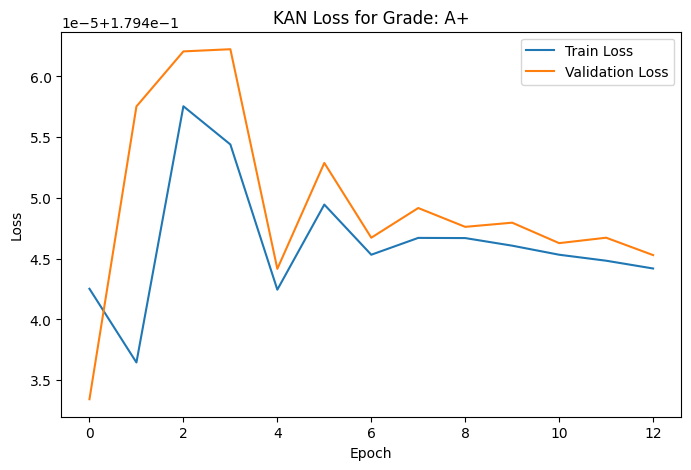

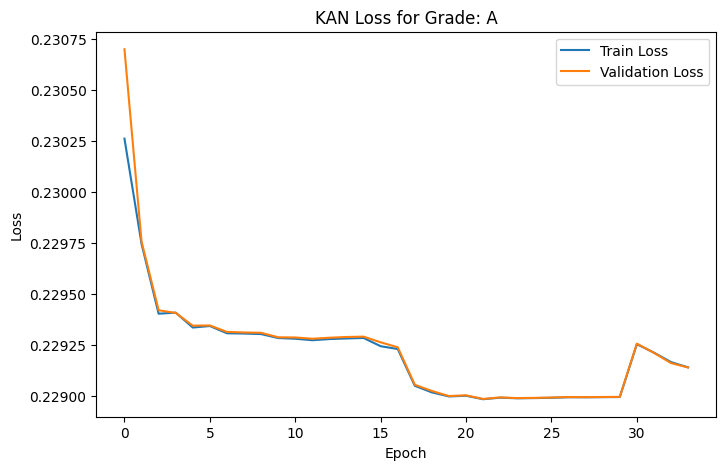

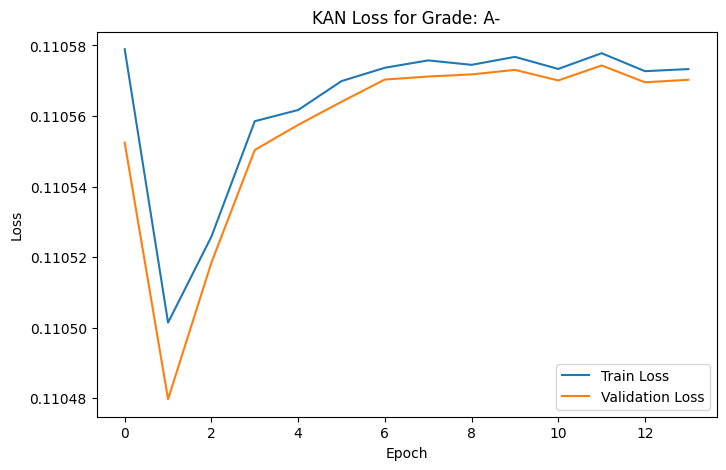

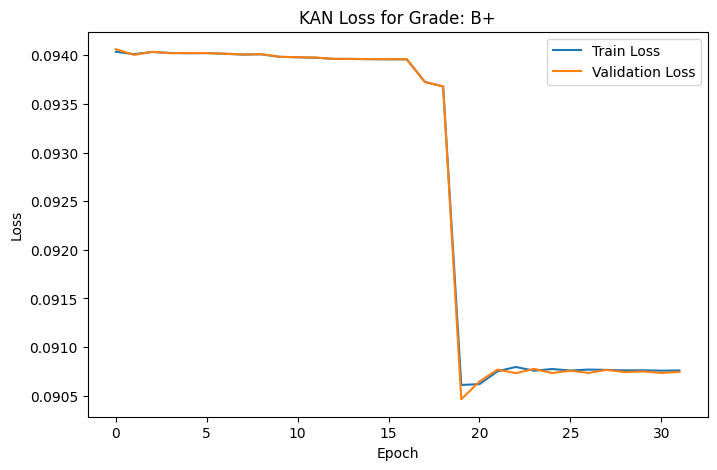

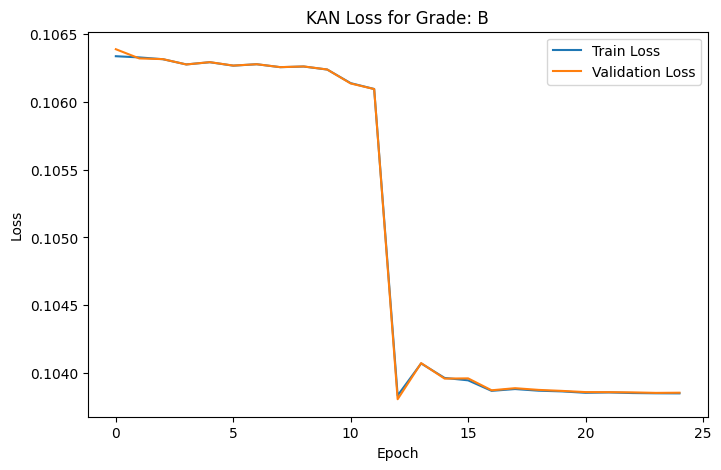

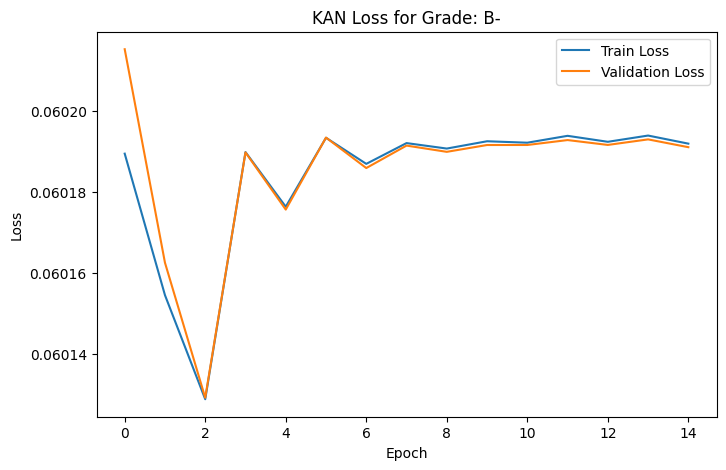

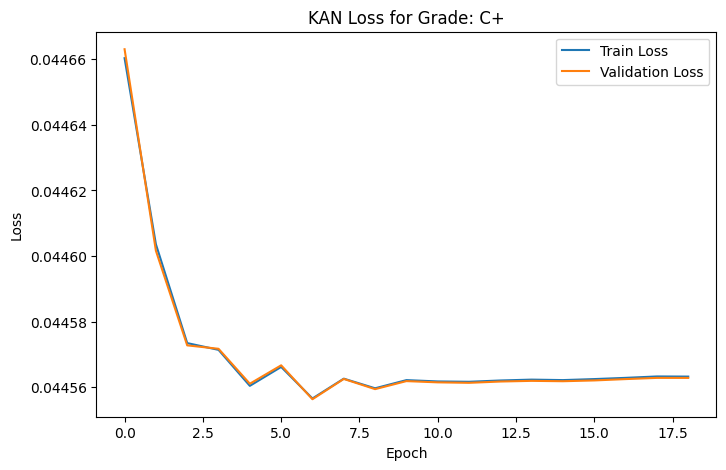

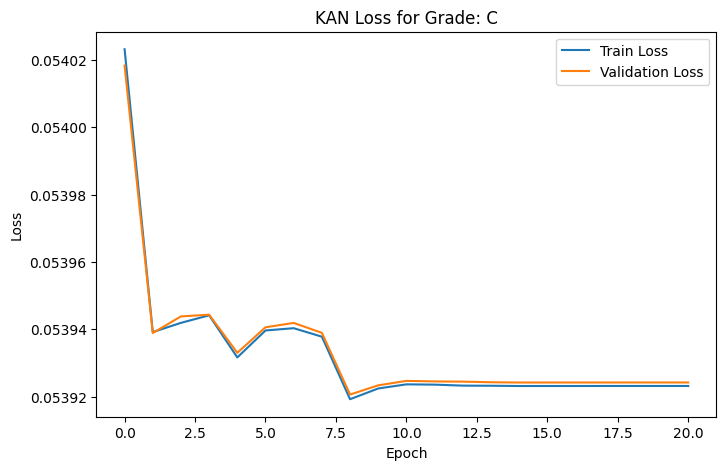

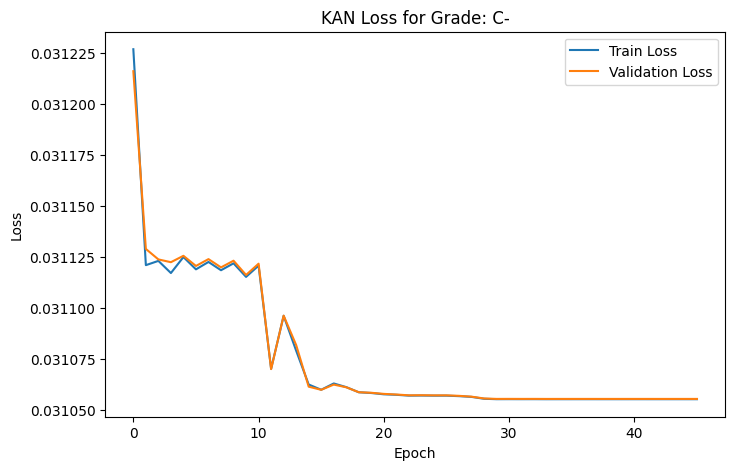

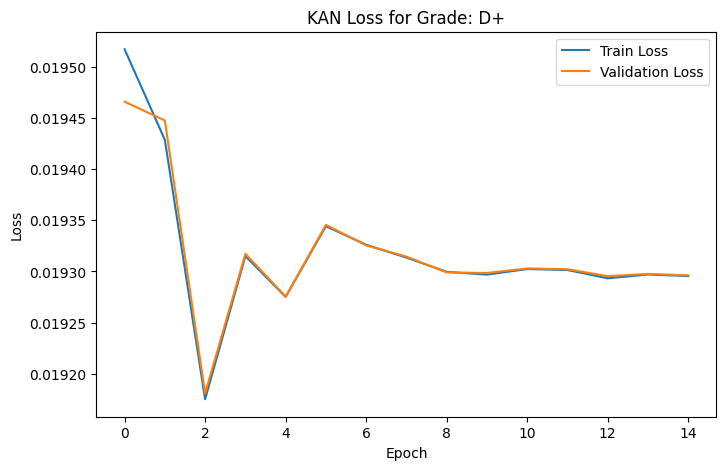

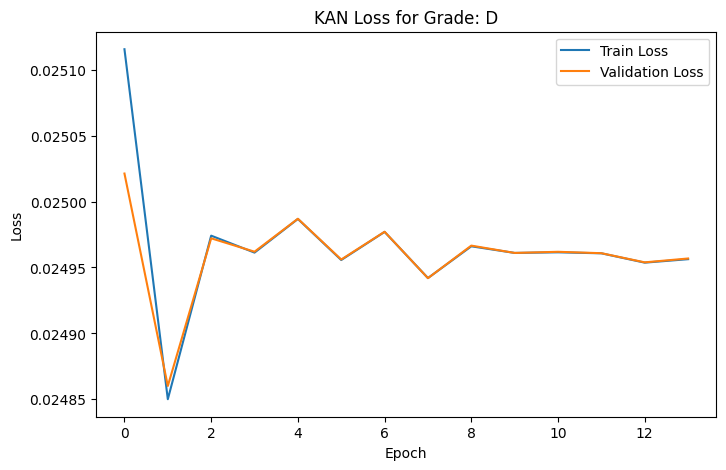

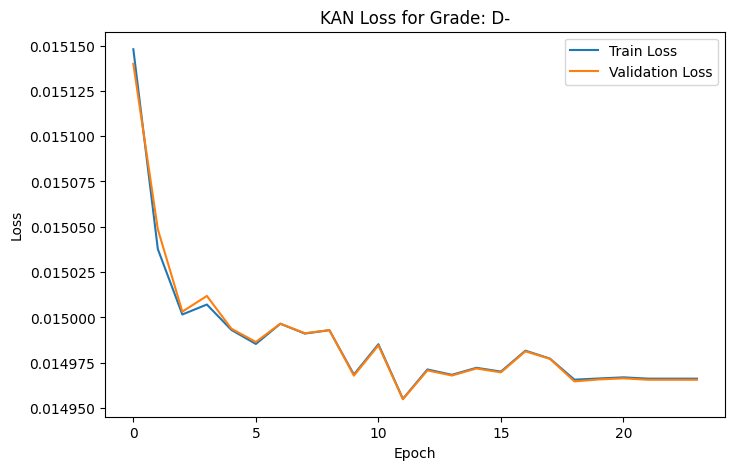

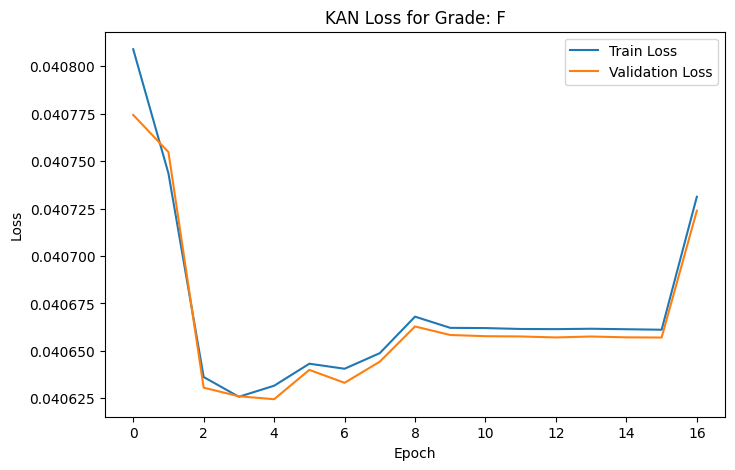

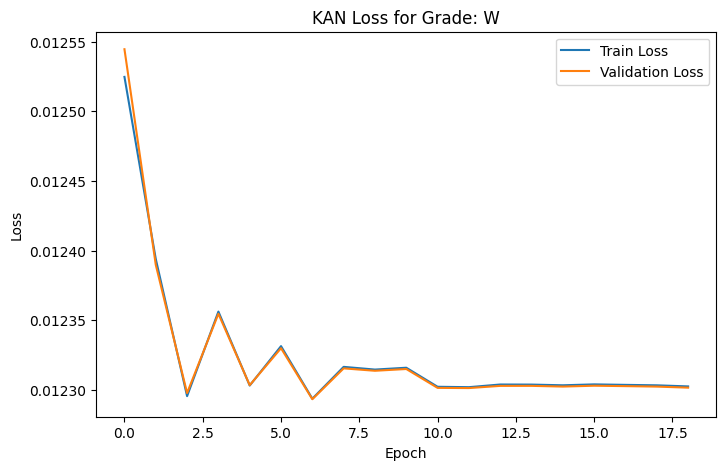

In [ ]:
from kan import KAN
import matplotlib.pyplot as plt
def train_kan_model_with_refine(kan_info, grids, k, steps, lamb=0.1, patience=5):
    """
    Train the KAN model with dynamic grid refinement and early stopping.

    Parameters:
    - kan_info: Dictionary containing KAN dataset information.
    - grids: List of grid sizes for dynamic grid refinement.
    - k: The k value for each neuron.
    - steps: The number of training steps for each grid.
    - lamb: Regularization strength.
    - patience: Early stopping tolerance.

    Returns:
    - model: The trained KAN model.
    - results: Dictionary containing training and validation losses.
    """
    kan_dataset = kan_info["dataset"]
    model = None
    best_val_loss = float("inf")
    counter = 0
    all_train_loss = []
    all_val_loss = []

    for grid in grids:
        # Dynamic grid expansion
        if model is None:
            model = KAN(width=[kan_info["n_var"],14,1], grid=grid, k=k, device=device)
        else:
            model = model.refine(grid)

        # Train the model
        for step in range(steps):
            # Pass the regularization parameter to the fit method
            results = model.fit(kan_dataset, opt="LBFGS", steps=1, lamb=lamb)
            train_loss = results["train_loss"][-1]
            val_loss = results["test_loss"][-1]

            # Record the losses
            all_train_loss.append(train_loss)
            all_val_loss.append(val_loss)

            # Early stopping logic
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                counter = 0  # Reset the counter
            else:
                counter += 1

            if counter >= patience:
                print(f"Early stopping triggered for grid {grid} at step {step}")
                break

    return model, {"train_loss": all_train_loss, "test_loss": all_val_loss}

# Start training
grids = [3]  # Grid sizes for dynamic grid refinement
steps = 50  # Maximum training steps for each grid
k = 3  # The k value for each neuron
lamb = 0.1  # Regularization strength
patience = 12  # Early stopping tolerance

trained_kan_models = {}
experiment_results = {}

for grade in grade_columns:
    print(f"Training KAN for grade: {grade}")
    train_info = work_train_kan_datasets[grade]

    model, results = train_kan_model_with_refine(
        train_info, grids=grids, k=k, steps=steps, lamb=lamb, patience=patience
    )
    trained_kan_models[grade] = model
    experiment_results[grade] = results

# Plot the loss curves for each grade
for grade in grade_columns:
    results = experiment_results[grade]
    plt.figure(figsize=(8, 5))
    plt.plot(results["train_loss"], label="Train Loss")
    plt.plot(results["test_loss"], label="Validation Loss")
    plt.title(f"KAN Loss for Grade: {grade}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


In [ ]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
debug_train_kan_datasets = dataloader_to_kan_dataset(debug_train_loader, grade_columns, device)
debug_val_kan_datasets = dataloader_to_kan_dataset(debug_val_loader, grade_columns, device)

for grade in grade_columns:
    kan_info = debug_train_kan_datasets[grade]
    print(f"Grade: {grade}, Number of Variables: {kan_info['n_var']}, Target Shape: {kan_info['targets'].shape}")

Using device: cuda
Grade: A+, Number of Variables: 760, Target Shape: torch.Size([2065])
Grade: A, Number of Variables: 760, Target Shape: torch.Size([2065])
Grade: A-, Number of Variables: 760, Target Shape: torch.Size([2065])
Grade: B+, Number of Variables: 760, Target Shape: torch.Size([2065])
Grade: B, Number of Variables: 760, Target Shape: torch.Size([2065])
Grade: B-, Number of Variables: 760, Target Shape: torch.Size([2065])
Grade: C+, Number of Variables: 760, Target Shape: torch.Size([2065])
Grade: C, Number of Variables: 760, Target Shape: torch.Size([2065])
Grade: C-, Number of Variables: 760, Target Shape: torch.Size([2065])
Grade: D+, Number of Variables: 760, Target Shape: torch.Size([2065])
Grade: D, Number of Variables: 760, Target Shape: torch.Size([2065])
Grade: D-, Number of Variables: 760, Target Shape: torch.Size([2065])
Grade: F, Number of Variables: 760, Target Shape: torch.Size([2065])
Grade: W, Number of Variables: 760, Target Shape: torch.Size([2065])


**KAN（var，2,1）**

Training KAN for grade: A+
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.69e-01 | test_loss: 1.69e-01 | reg: 1.58e+01 | : 100%|█| 1/1 [00:02<00:00,  2.12s/it


saving model version 0.1


| train_loss: 1.69e-01 | test_loss: 1.69e-01 | reg: 1.56e+01 | : 100%|█| 1/1 [00:01<00:00,  1.69s/it


saving model version 0.2


| train_loss: 1.69e-01 | test_loss: 1.69e-01 | reg: 1.55e+01 | : 100%|█| 1/1 [00:01<00:00,  1.85s/it


saving model version 0.3


| train_loss: 1.69e-01 | test_loss: 1.69e-01 | reg: 1.55e+01 | : 100%|█| 1/1 [00:01<00:00,  1.56s/it


saving model version 0.4


| train_loss: 1.69e-01 | test_loss: 1.69e-01 | reg: 1.55e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.5
Training KAN for grade: A
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.34e-01 | test_loss: 2.34e-01 | reg: 1.57e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.1


| train_loss: 2.34e-01 | test_loss: 2.34e-01 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.2


| train_loss: 2.34e-01 | test_loss: 2.34e-01 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.64s/it


saving model version 0.3


| train_loss: 2.34e-01 | test_loss: 2.34e-01 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.80s/it


saving model version 0.4


| train_loss: 2.34e-01 | test_loss: 2.34e-01 | reg: 1.51e+01 | : 100%|█| 1/1 [00:01<00:00,  1.57s/it


saving model version 0.5
Training KAN for grade: A-
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.19e-01 | test_loss: 1.19e-01 | reg: 1.59e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.1


| train_loss: 1.19e-01 | test_loss: 1.19e-01 | reg: 1.55e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.2


| train_loss: 1.19e-01 | test_loss: 1.19e-01 | reg: 1.55e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.3


| train_loss: 1.19e-01 | test_loss: 1.19e-01 | reg: 1.55e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.4


| train_loss: 1.19e-01 | test_loss: 1.19e-01 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.74s/it


saving model version 0.5
Training KAN for grade: B+
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 8.95e-02 | test_loss: 8.95e-02 | reg: 1.58e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.1


| train_loss: 8.94e-02 | test_loss: 8.94e-02 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.2


| train_loss: 8.95e-02 | test_loss: 8.95e-02 | reg: 1.51e+01 | : 100%|█| 1/1 [00:01<00:00,  1.57s/it


saving model version 0.3


| train_loss: 8.95e-02 | test_loss: 8.95e-02 | reg: 1.51e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.4
Early stopping triggered for grid 3 at step 3
Training KAN for grade: B
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.07e-01 | test_loss: 1.06e-01 | reg: 1.57e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.1


| train_loss: 1.06e-01 | test_loss: 1.06e-01 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.75s/it


saving model version 0.2


| train_loss: 1.06e-01 | test_loss: 1.06e-01 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.73s/it


saving model version 0.3


| train_loss: 1.06e-01 | test_loss: 1.06e-01 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.4
Early stopping triggered for grid 3 at step 3
Training KAN for grade: B-
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.28e-02 | test_loss: 6.28e-02 | reg: 1.56e+01 | : 100%|█| 1/1 [00:01<00:00,  1.99s/it


saving model version 0.1


| train_loss: 6.27e-02 | test_loss: 6.27e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:02<00:00,  2.16s/it


saving model version 0.2


| train_loss: 6.27e-02 | test_loss: 6.27e-02 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.3


| train_loss: 6.27e-02 | test_loss: 6.27e-02 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.77s/it


saving model version 0.4


| train_loss: 6.27e-02 | test_loss: 6.27e-02 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.68s/it


saving model version 0.5
Early stopping triggered for grid 3 at step 4
Training KAN for grade: C+
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 4.21e-02 | test_loss: 4.21e-02 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.1


| train_loss: 4.20e-02 | test_loss: 4.20e-02 | reg: 1.47e+01 | : 100%|█| 1/1 [00:01<00:00,  1.61s/it


saving model version 0.2


| train_loss: 4.19e-02 | test_loss: 4.19e-02 | reg: 1.46e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.3


| train_loss: 4.19e-02 | test_loss: 4.19e-02 | reg: 1.46e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.4


| train_loss: 4.19e-02 | test_loss: 4.19e-02 | reg: 1.45e+01 | : 100%|█| 1/1 [00:01<00:00,  1.74s/it


saving model version 0.5
Training KAN for grade: C
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.75e-02 | test_loss: 5.75e-02 | reg: 1.57e+01 | : 100%|█| 1/1 [00:01<00:00,  1.71s/it


saving model version 0.1


| train_loss: 5.74e-02 | test_loss: 5.74e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.2


| train_loss: 5.74e-02 | test_loss: 5.74e-02 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.3


| train_loss: 5.74e-02 | test_loss: 5.74e-02 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.60s/it


saving model version 0.4
Early stopping triggered for grid 3 at step 3
Training KAN for grade: C-
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.02e-02 | test_loss: 3.02e-02 | reg: 1.58e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.1


| train_loss: 3.01e-02 | test_loss: 3.01e-02 | reg: 1.55e+01 | : 100%|█| 1/1 [00:01<00:00,  1.72s/it


saving model version 0.2


| train_loss: 3.01e-02 | test_loss: 3.01e-02 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.79s/it


saving model version 0.3


| train_loss: 3.01e-02 | test_loss: 3.01e-02 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.4


| train_loss: 3.01e-02 | test_loss: 3.01e-02 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.5
Early stopping triggered for grid 3 at step 4
Training KAN for grade: D+
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.85e-02 | test_loss: 1.87e-02 | reg: 1.58e+01 | : 100%|█| 1/1 [00:01<00:00,  1.60s/it


saving model version 0.1


| train_loss: 1.84e-02 | test_loss: 1.84e-02 | reg: 1.51e+01 | : 100%|█| 1/1 [00:01<00:00,  1.60s/it


saving model version 0.2


| train_loss: 1.84e-02 | test_loss: 1.84e-02 | reg: 1.50e+01 | : 100%|█| 1/1 [00:01<00:00,  1.63s/it


saving model version 0.3


| train_loss: 1.84e-02 | test_loss: 1.85e-02 | reg: 1.49e+01 | : 100%|█| 1/1 [00:01<00:00,  1.78s/it


saving model version 0.4


| train_loss: 1.84e-02 | test_loss: 1.84e-02 | reg: 1.49e+01 | : 100%|█| 1/1 [00:01<00:00,  1.60s/it


saving model version 0.5
Early stopping triggered for grid 3 at step 4
Training KAN for grade: D
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 2.38e-02 | test_loss: 2.38e-02 | reg: 1.58e+01 | : 100%|█| 1/1 [00:01<00:00,  1.60s/it


saving model version 0.1


| train_loss: 2.37e-02 | test_loss: 2.37e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.2


| train_loss: 2.36e-02 | test_loss: 2.36e-02 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.61s/it


saving model version 0.3


| train_loss: 2.37e-02 | test_loss: 2.37e-02 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.60s/it


saving model version 0.4


| train_loss: 2.37e-02 | test_loss: 2.37e-02 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.76s/it


saving model version 0.5
Early stopping triggered for grid 3 at step 4
Training KAN for grade: D-
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.75e-02 | test_loss: 1.77e-02 | reg: 1.52e+01 | : 100%|█| 1/1 [00:01<00:00,  1.60s/it


saving model version 0.1


| train_loss: 1.72e-02 | test_loss: 1.72e-02 | reg: 1.43e+01 | : 100%|█| 1/1 [00:01<00:00,  1.82s/it


saving model version 0.2


| train_loss: 1.69e-02 | test_loss: 1.69e-02 | reg: 1.42e+01 | : 100%|█| 1/1 [00:01<00:00,  1.56s/it


saving model version 0.3


| train_loss: 1.69e-02 | test_loss: 1.69e-02 | reg: 1.41e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.4


| train_loss: 1.69e-02 | test_loss: 1.68e-02 | reg: 1.41e+01 | : 100%|█| 1/1 [00:01<00:00,  1.58s/it


saving model version 0.5
Training KAN for grade: F
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 3.14e-02 | test_loss: 3.15e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.79s/it


saving model version 0.1


| train_loss: 3.12e-02 | test_loss: 3.12e-02 | reg: 1.45e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.2


| train_loss: 3.11e-02 | test_loss: 3.10e-02 | reg: 1.44e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.3


| train_loss: 3.11e-02 | test_loss: 3.11e-02 | reg: 1.43e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.4


| train_loss: 3.11e-02 | test_loss: 3.10e-02 | reg: 1.43e+01 | : 100%|█| 1/1 [00:01<00:00,  1.60s/it


saving model version 0.5
Training KAN for grade: W
checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.28e-02 | test_loss: 1.29e-02 | reg: 1.57e+01 | : 100%|█| 1/1 [00:01<00:00,  1.71s/it


saving model version 0.1


| train_loss: 1.27e-02 | test_loss: 1.27e-02 | reg: 1.54e+01 | : 100%|█| 1/1 [00:01<00:00,  1.93s/it


saving model version 0.2


| train_loss: 1.27e-02 | test_loss: 1.27e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.97s/it


saving model version 0.3


| train_loss: 1.27e-02 | test_loss: 1.27e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.4


| train_loss: 1.27e-02 | test_loss: 1.27e-02 | reg: 1.53e+01 | : 100%|█| 1/1 [00:01<00:00,  1.59s/it


saving model version 0.5


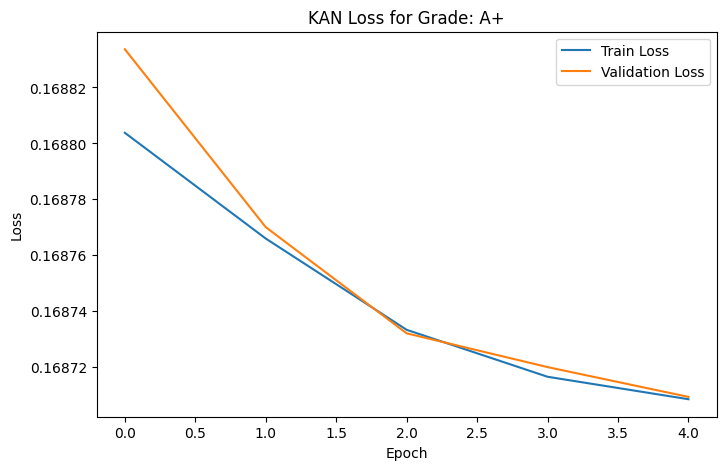

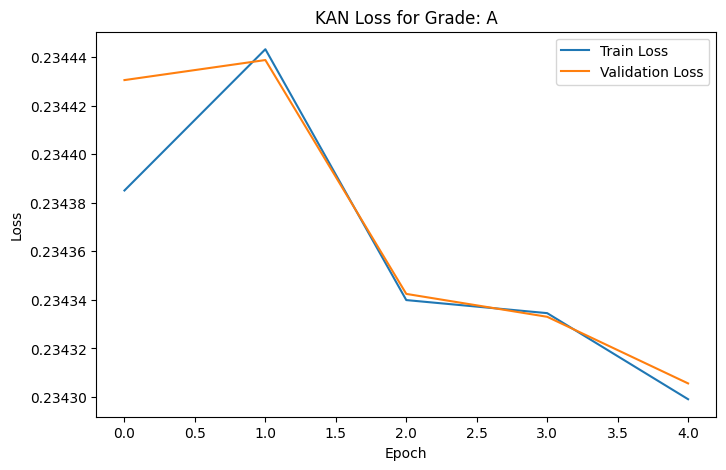

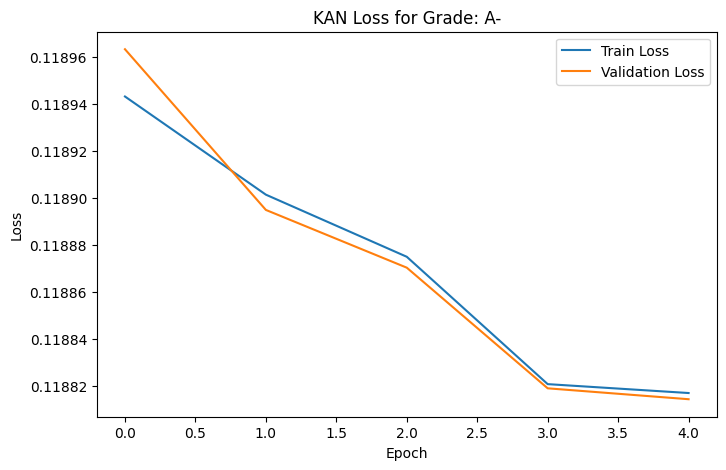

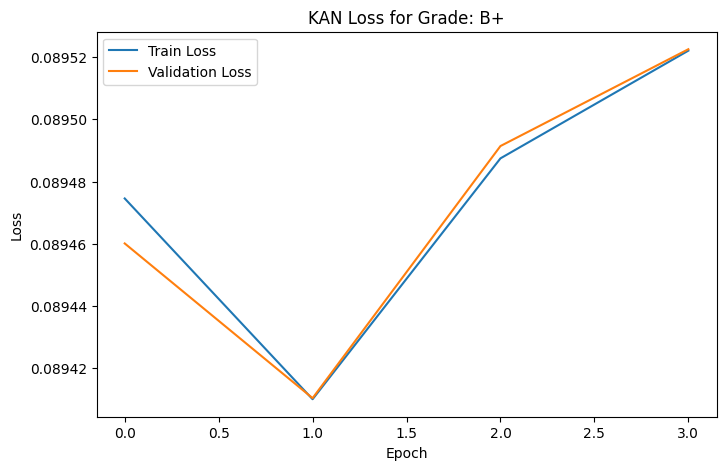

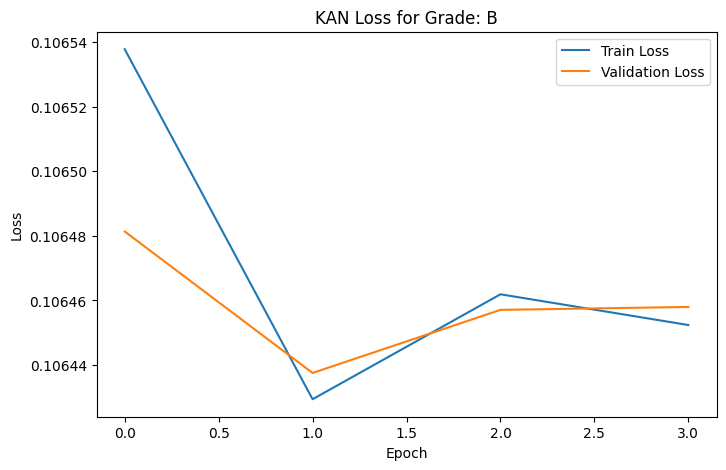

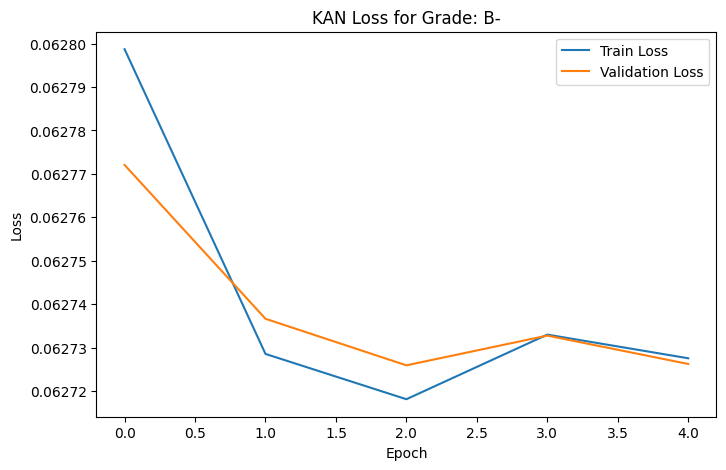

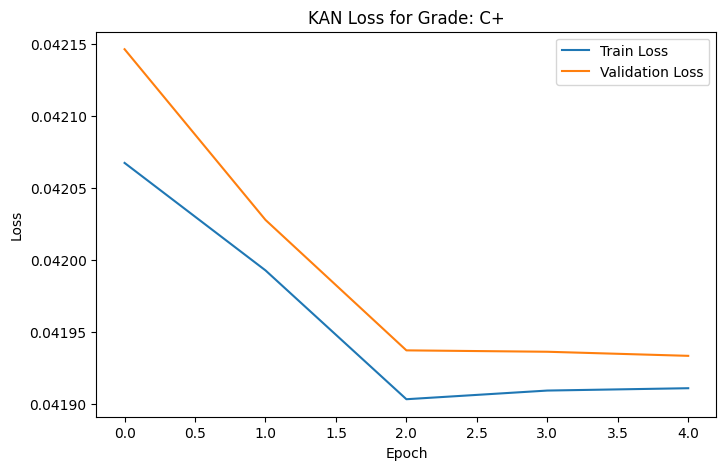

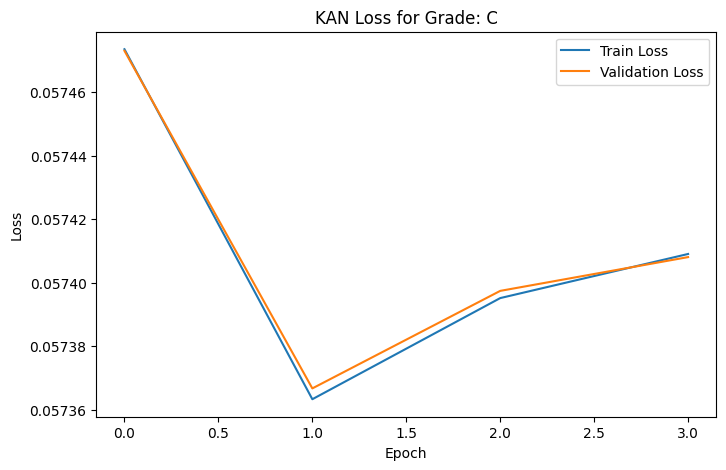

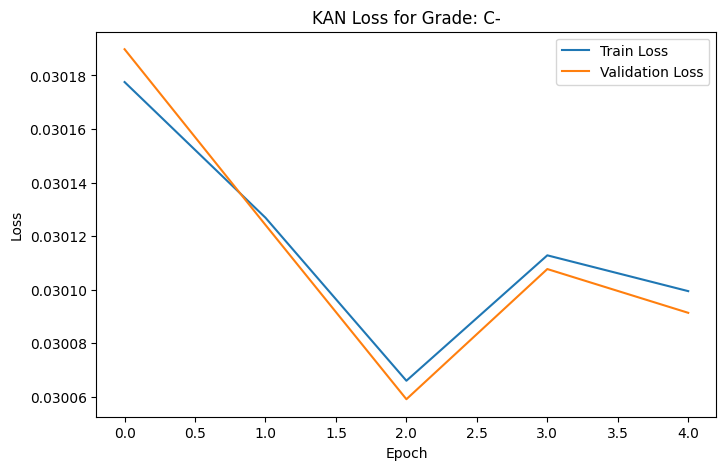

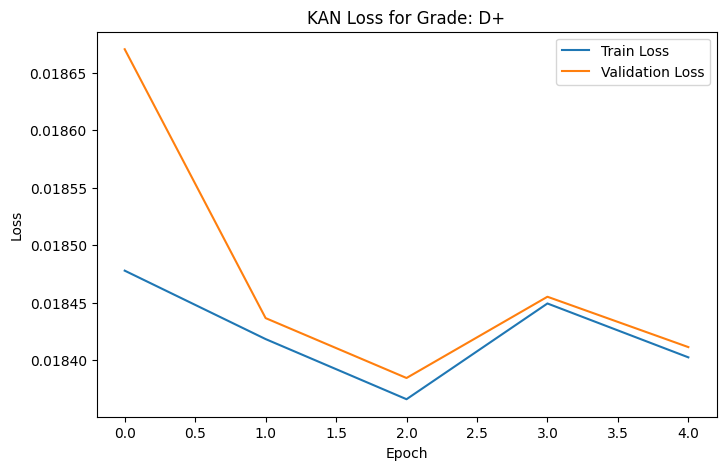

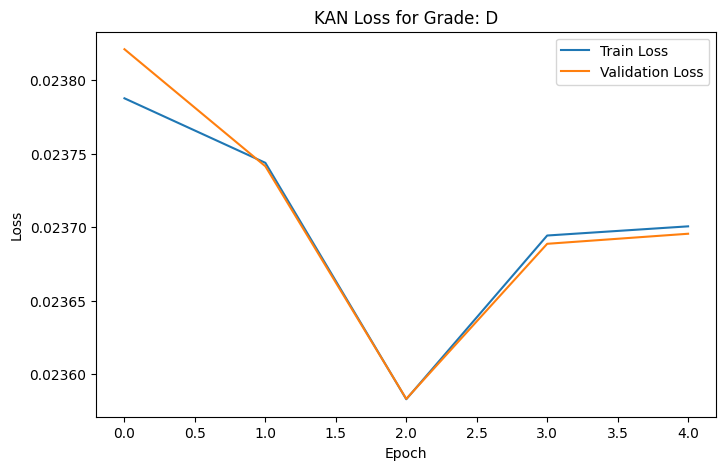

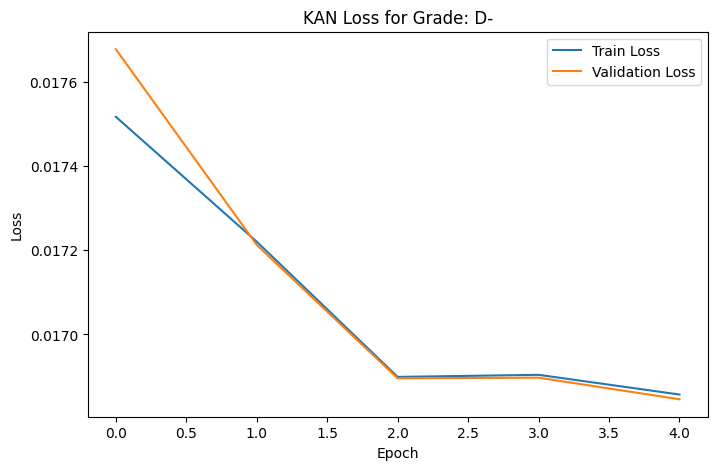

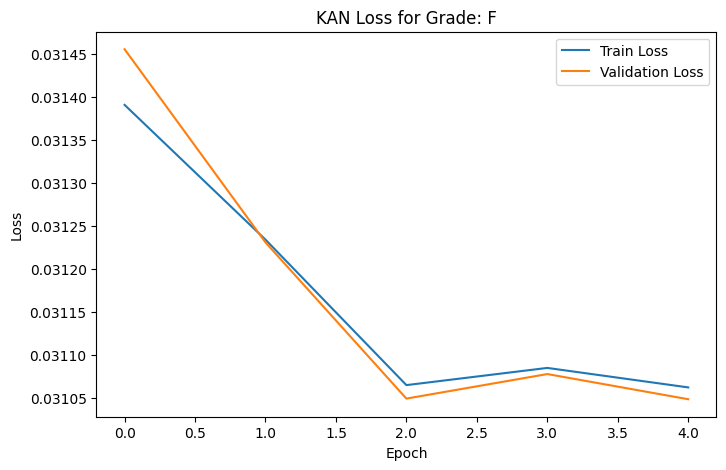

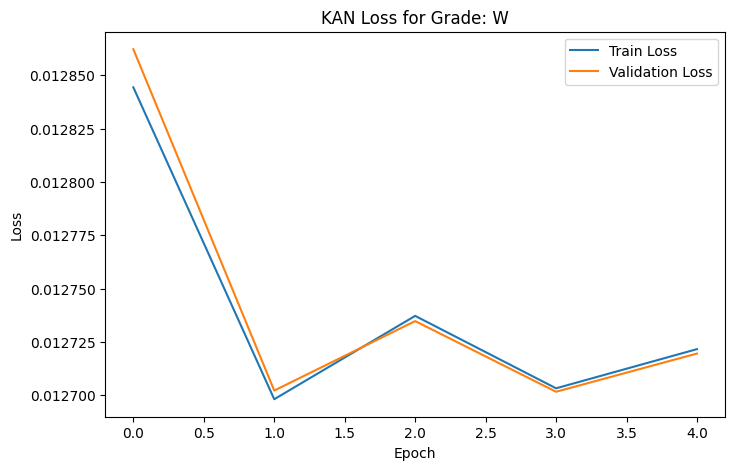

In [ ]:
import torch
from kan import KAN
import matplotlib.pyplot as plt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def train_kan_model_with_refine(kan_info, grids, k, steps, lamb=0.1, patience=2):
    """
    Train the KAN model with dynamic grid refinement and early stopping.
    """
    kan_dataset = kan_info["dataset"]
    model = None
    best_val_loss = float("inf")
    counter = 0
    all_train_loss = []
    all_val_loss = []

    for grid in grids:
        # Dynamic grid expansion
        if model is None:
            model = KAN(width=[kan_info["n_var"],14,1], grid=grid, k=k, device=device)
        else:
            model = model.refine(grid)

        # Train the model with fewer steps
        for step in range(steps):
            results = model.fit(kan_dataset, opt="LBFGS", steps=1, lamb=lamb)
            train_loss = results["train_loss"][-1]
            val_loss = results["test_loss"][-1]

            # Record the losses
            all_train_loss.append(train_loss)
            all_val_loss.append(val_loss)

            # Early stopping logic
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                counter = 0  # Reset the counter
            else:
                counter += 1

            if counter >= patience:
                print(f"Early stopping triggered for grid {grid} at step {step}")
                break

    return model, {"train_loss": all_train_loss, "test_loss": all_val_loss}

# Start training with fewer steps and smaller grid size
grids = [3]  # Smaller grid size for faster training
steps = 5  # Fewer training steps
k = 3  # The k value for each neuron
lamb = 0.1  # Regularization strength
patience = 2  # Early stopping tolerance

trained_kan_models = {}
experiment_results = {}

for grade in grade_columns:
    print(f"Training KAN for grade: {grade}")
    train_info = debug_train_kan_datasets[grade]

    model, results = train_kan_model_with_refine(
        train_info, grids=grids, k=k, steps=steps, lamb=lamb, patience=patience
    )
    trained_kan_models[grade] = model
    experiment_results[grade] = results

# Plot the loss curves for each grade
for grade in grade_columns:
    results = experiment_results[grade]
    plt.figure(figsize=(8, 5))
    plt.plot(results["train_loss"], label="Train Loss")
    plt.plot(results["test_loss"], label="Validation Loss")
    plt.title(f"KAN Loss for Grade: {grade}")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import torch
import pandas as pd
import numpy as np

# Ensure the device is set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize lists to store results for visualization
grades = []  # To store grade names
mae_values = []  # To store MAE for each grade
rmse_values = []  # To store RMSE for each grade
grade_distributions = []  # To store predicted grade distributions

# Evaluate each model for the grades
for grade in grade_columns:  # Replace grade_columns with your actual list of grades
    print(f"Evaluating KAN for grade: {grade}")

    # Retrieve the trained model for this grade
    model = trained_kan_models[grade]  # Replace trained_kan_models with your actual model dictionary
    model.eval()  # Set the model to evaluation mode

    # Get the test dataset for this grade
    kan_info = kan_datasets[grade]  # Replace kan_datasets with your actual dataset dictionary
    features, targets = kan_info["dataset"]  # features is a tensor, targets is the label tensor

    # Make predictions
    with torch.no_grad():
        predictions = model(features.to(device))

    # Convert predictions and targets to numpy for evaluation
    true_values = targets.cpu().numpy()
    predicted_values = predictions.cpu().numpy()

    # Calculate Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE)
    mae = mean_absolute_error(true_values, predicted_values)
    rmse = mean_squared_error(true_values, predicted_values, squared=False)

    # Append results to lists
    grades.append(grade)
    mae_values.append(mae)
    rmse_values.append(rmse)

    # Store predicted grade distributions
    grade_distributions.append((true_values, predicted_values))

    # Output the results
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Compare Actual and Predicted Grade Distributions
actual_grade_distribution = []
predicted_grade_distribution = []

# Calculate grade distributions
for true_values, predicted_values in grade_distributions:
    actual_distribution = np.mean(true_values) * 100  # Assuming binary classification for each grade
    predicted_distribution = np.mean(predicted_values) * 100
    actual_grade_distribution.append(actual_distribution)
    predicted_grade_distribution.append(predicted_distribution)

# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'Grade': grades,
    'Actual Distribution (%)': actual_grade_distribution,
    'Predicted Distribution (%)': predicted_grade_distribution
})

# Display the comparison
print("\nComparison of Actual and Predicted Grade Distribution (Percentage):")
print(comparison_df)

# Plot the comparison
comparison_df.set_index('Grade').plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange'], edgecolor='black')
plt.title('Comparison of Actual and Predicted Grade Distribution')
plt.xlabel('Grades')
plt.ylabel('Percentage')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.legend(title='Distribution')
plt.tight_layout()

# Display the plot
plt.show()

# Calculate overall distribution errors
distribution_mae = np.mean(np.abs(np.array(actual_grade_distribution) - np.array(predicted_grade_distribution)))
distribution_rmse = np.sqrt(np.mean((np.array(actual_grade_distribution) - np.array(predicted_grade_distribution)) ** 2))
print(f"\nOverall MAE of Grade Distribution: {distribution_mae:.4f}%")
print(f"Overall RMSE of Grade Distribution: {distribution_rmse:.4f}%")

In [ ]:
debug_test_kan_datasets = dataloader_to_kan_dataset(debug_test_loader, grade_columns, device)

In [ ]:
features = {col: features[col].to(device) for col in features}


In [ ]:
def dataloader_to_kan_dataset1(dataloader, grade_columns, device):
    """
    Extracts data from the DataLoader and converts it into a format suitable for KAN.

    Returns:
    - kan_datasets: A dictionary where keys are grade column names, and values are dictionaries
      containing KAN dataset, feature count, and target values.
    """
    kan_datasets = {}

    for grade in grade_columns:
        features_list = []
        targets_list = []

        # Iterate over the batches in the DataLoader
        for batch in dataloader:
            features, targets = batch

            # Ensure features is a dictionary
            # If features is not a dictionary, convert it to one
            if isinstance(features, dict):
                feature_dict = features
            else:
                feature_dict = {col: features[col] for col in features}

            # Stack features by columns (if necessary) and move to the right device
            feature_tensor = torch.cat([feature_dict[col] for col in feature_dict], dim=1).to(device)
            features_list.append(feature_tensor)
            targets_list.append(targets[:, grade_columns.index(grade)])  # Get the target for this grade

        # Combine all batches
        feature_matrix = torch.cat(features_list, dim=0).to(device)
        targets = torch.cat(targets_list, dim=0).to(device)

        # Store dataset information for this grade
        kan_datasets[grade] = {
            "dataset": (feature_matrix, targets),
            "n_var": feature_matrix.shape[1],
            "targets": targets
        }

    return kan_datasets


In [ ]:
import torch

# Assuming you already have dataloader_to_kan_dataset1 and trained_kan_models dictionary
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Evaluate for grade 'A+'
kan_datasets = dataloader_to_kan_dataset1(debug_test_loader, grade_columns, device)
kan_info = kan_datasets['A+']  # Get the data for 'A+'
features, targets = kan_info['dataset']  # Extract feature matrix and target values

# Print the type and shape of features and targets to understand their structure
print(f"Features Type: {type(features)}")  # Print the type of the features
print(f"Features Shape: {features.shape}")  # Print the shape of the features
print(f"Targets Shape: {targets.shape}")  # Print the shape of the targets

# Now, pass the features and targets into the model for evaluation
model.eval()  # Set the model to evaluation mode
with torch.no_grad():  # No need to compute gradients during evaluation
    outputs = model(features)  # Get the model's predictions

# Print the shape of the model's output to verify the predictions
print(f"Model Outputs Shape: {outputs.shape}")  # Print the shape of the model outputs


Features Type: <class 'torch.Tensor'>
Features Shape: torch.Size([443, 760])
Targets Shape: torch.Size([443])
Model Outputs Shape: torch.Size([443, 1])


Using device: cuda
Evaluating KAN for grade: A+


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Absolute Error (MAE): 0.1139
Root Mean Squared Error (RMSE): 0.1735
Evaluating KAN for grade: A


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Absolute Error (MAE): 0.1627
Root Mean Squared Error (RMSE): 0.2219
Evaluating KAN for grade: A-


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Absolute Error (MAE): 0.0857
Root Mean Squared Error (RMSE): 0.1154
Evaluating KAN for grade: B+


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Absolute Error (MAE): 0.0687
Root Mean Squared Error (RMSE): 0.0941
Evaluating KAN for grade: B


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Absolute Error (MAE): 0.0758
Root Mean Squared Error (RMSE): 0.1012
Evaluating KAN for grade: B-


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Absolute Error (MAE): 0.0457
Root Mean Squared Error (RMSE): 0.0609
Evaluating KAN for grade: C+


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Absolute Error (MAE): 0.0312
Root Mean Squared Error (RMSE): 0.0428
Evaluating KAN for grade: C


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Absolute Error (MAE): 0.0368
Root Mean Squared Error (RMSE): 0.0505
Evaluating KAN for grade: C-


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Absolute Error (MAE): 0.0184
Root Mean Squared Error (RMSE): 0.0281
Evaluating KAN for grade: D+


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Absolute Error (MAE): 0.0092
Root Mean Squared Error (RMSE): 0.0231
Evaluating KAN for grade: D


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Absolute Error (MAE): 0.0141
Root Mean Squared Error (RMSE): 0.0257
Evaluating KAN for grade: D-


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Absolute Error (MAE): 0.0105
Root Mean Squared Error (RMSE): 0.0251
Evaluating KAN for grade: F


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Absolute Error (MAE): 0.0203
Root Mean Squared Error (RMSE): 0.0366
Evaluating KAN for grade: W


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Absolute Error (MAE): 0.0054
Root Mean Squared Error (RMSE): 0.0115


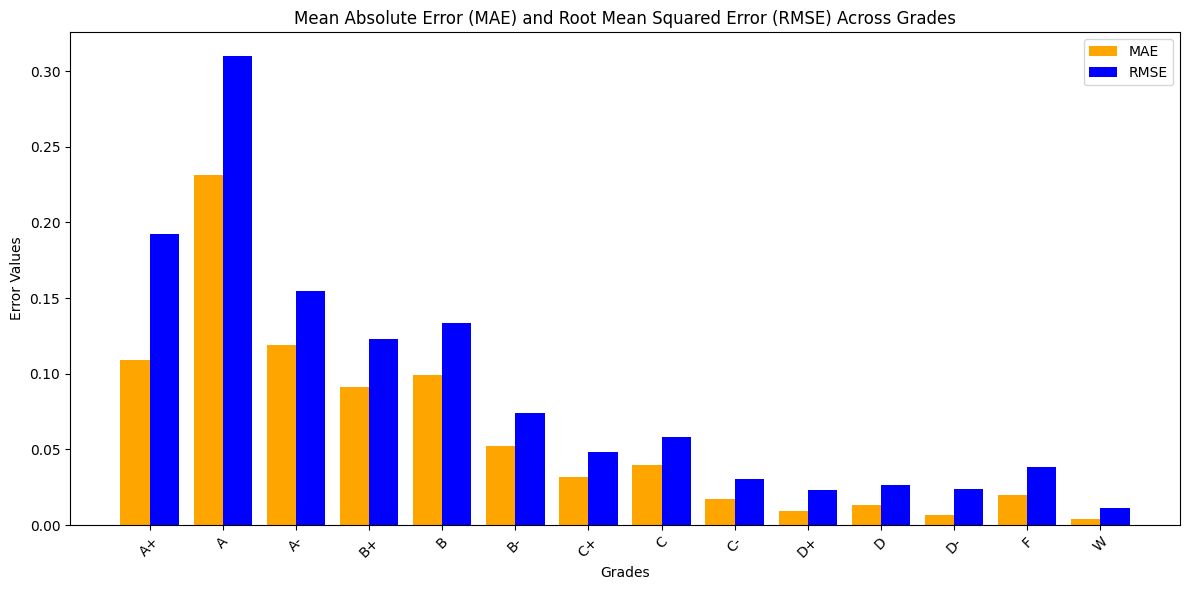

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import torch

# Ensure the device is set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Evaluate each model for the grades
for grade in grade_columns:
    print(f"Evaluating KAN for grade: {grade}")

    # Retrieve the trained model for this grade
    model = trained_kan_models[grade]
    model.eval()  # Set the model to evaluation mode

    # Get the test dataset for this grade
    kan_info = kan_datasets[grade]
    features, targets = kan_info["dataset"]  # features is a tensor, targets is the label

    # Make predictions
    with torch.no_grad():
        predictions = model(features.to(device))

    # Convert predictions and targets to numpy for evaluation
    true_values = targets.cpu().numpy()
    predicted_values = predictions.cpu().numpy()

    # Calculate Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE)
    mae = mean_absolute_error(true_values, predicted_values)
    rmse = mean_squared_error(true_values, predicted_values, squared=False)

    # Output the results
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Visualization of MAE and RMSE across grades
plt.figure(figsize=(12, 6))

# Plot MAE values
plt.bar(range(len(grades)), mae_values, width=0.4, label="MAE", color="orange", align="center")

# Plot RMSE values
plt.bar([x + 0.4 for x in range(len(grades))], rmse_values, width=0.4, label="RMSE", color="blue", align="center")

# Customize the plot
plt.xticks([x + 0.2 for x in range(len(grades))], grades, rotation=45)
plt.xlabel("Grades")
plt.ylabel("Error Values")
plt.title("Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) Across Grades")
plt.legend()
plt.tight_layout()

# Display the plot
plt.show()


Using device: cuda
Evaluating KAN for grade: A+


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Absolute Error (MAE): 0.1117
Root Mean Squared Error (RMSE): 0.1752
Evaluating KAN for grade: A


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Absolute Error (MAE): 0.1627
Root Mean Squared Error (RMSE): 0.2219
Evaluating KAN for grade: A-


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Absolute Error (MAE): 0.0857
Root Mean Squared Error (RMSE): 0.1154
Evaluating KAN for grade: B+


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Absolute Error (MAE): 0.0687
Root Mean Squared Error (RMSE): 0.0941
Evaluating KAN for grade: B


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Absolute Error (MAE): 0.0758
Root Mean Squared Error (RMSE): 0.1012
Evaluating KAN for grade: B-


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Absolute Error (MAE): 0.0457
Root Mean Squared Error (RMSE): 0.0609
Evaluating KAN for grade: C+


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Absolute Error (MAE): 0.0312
Root Mean Squared Error (RMSE): 0.0428
Evaluating KAN for grade: C


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Absolute Error (MAE): 0.0368
Root Mean Squared Error (RMSE): 0.0506
Evaluating KAN for grade: C-


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Absolute Error (MAE): 0.0184
Root Mean Squared Error (RMSE): 0.0281
Evaluating KAN for grade: D+


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Absolute Error (MAE): 0.0092
Root Mean Squared Error (RMSE): 0.0231
Evaluating KAN for grade: D


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Absolute Error (MAE): 0.0141
Root Mean Squared Error (RMSE): 0.0257
Evaluating KAN for grade: D-


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Absolute Error (MAE): 0.0105
Root Mean Squared Error (RMSE): 0.0251
Evaluating KAN for grade: F


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Absolute Error (MAE): 0.0203
Root Mean Squared Error (RMSE): 0.0366
Evaluating KAN for grade: W


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Mean Absolute Error (MAE): 0.0054
Root Mean Squared Error (RMSE): 0.0116

Comparison of Actual and Predicted Grade Distribution (Percentage):
   Grade  Actual Distribution (%)  Predicted Distribution (%)
0     A+                11.666764                    7.936236
1      A                31.044266                   25.639349
2     A-                14.514002                   10.707160
3     B+                10.925988                    8.524419
4      B                12.341539                    9.547321
5     B-                 5.549854                    3.983642
6     C+                 3.195335                    2.021728
7      C                 4.145876                    2.664502
8     C-                 1.606682                    0.802749
9     D+                 0.888642                    0.035804
10     D                 1.256238                    0.401792
11    D-                 0.643595                    0.403078
12     F                 1.890564                   

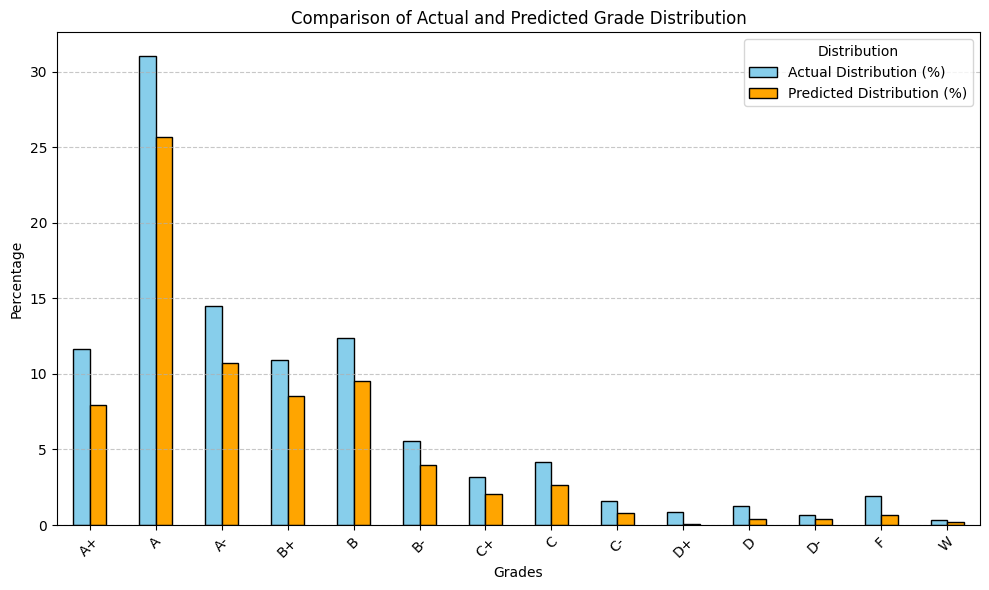


Overall MAE of Grade Distribution: 1.8900%
Overall RMSE of Grade Distribution: 2.4041%


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import torch
import pandas as pd
import numpy as np

# Ensure the device is set
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize lists to store results for visualization
grades = []  # To store grade names
mae_values = []  # To store MAE for each grade
rmse_values = []  # To store RMSE for each grade
grade_distributions = []  # To store predicted grade distributions

# Evaluate each model for the grades
for grade in grade_columns:  # Replace grade_columns with your actual list of grades
    print(f"Evaluating KAN for grade: {grade}")

    # Retrieve the trained model for this grade
    model = trained_kan_models[grade]  # Replace trained_kan_models with your actual model dictionary
    model.eval()  # Set the model to evaluation mode

    # Get the test dataset for this grade
    kan_info = kan_datasets[grade]  # Replace kan_datasets with your actual dataset dictionary
    features, targets = kan_info["dataset"]  # features is a tensor, targets is the label tensor

    # Make predictions
    with torch.no_grad():
        predictions = model(features.to(device))

    # Convert predictions and targets to numpy for evaluation
    true_values = targets.cpu().numpy()
    predicted_values = predictions.cpu().numpy()

    # Calculate Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE)
    mae = mean_absolute_error(true_values, predicted_values)
    rmse = mean_squared_error(true_values, predicted_values, squared=False)

    # Append results to lists
    grades.append(grade)
    mae_values.append(mae)
    rmse_values.append(rmse)

    # Store predicted grade distributions
    grade_distributions.append((true_values, predicted_values))

    # Output the results
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Compare Actual and Predicted Grade Distributions
actual_grade_distribution = []
predicted_grade_distribution = []

for true_values, predicted_values in grade_distributions:

    predicted_values = np.abs(predicted_values)

    actual_distribution = np.mean(true_values) * 100
    predicted_distribution = np.mean(predicted_values) * 100

    actual_grade_distribution.append(actual_distribution)
    predicted_grade_distribution.append(predicted_distribution)


# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'Grade': grades,
    'Actual Distribution (%)': actual_grade_distribution,
    'Predicted Distribution (%)': predicted_grade_distribution
})

# Display the comparison
print("\nComparison of Actual and Predicted Grade Distribution (Percentage):")
print(comparison_df)

# Plot the comparison
comparison_df.set_index('Grade').plot(kind='bar', figsize=(10, 6), color=['skyblue', 'orange'], edgecolor='black')
plt.title('Comparison of Actual and Predicted Grade Distribution')
plt.xlabel('Grades')
plt.ylabel('Percentage')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.legend(title='Distribution')
plt.tight_layout()

# Display the plot
plt.show()

# Calculate overall distribution errors
distribution_mae = np.mean(np.abs(np.array(actual_grade_distribution) - np.array(predicted_grade_distribution)))
distribution_rmse = np.sqrt(np.mean((np.array(actual_grade_distribution) - np.array(predicted_grade_distribution)) ** 2))
print(f"\nOverall MAE of Grade Distribution: {distribution_mae:.4f}%")
print(f"Overall RMSE of Grade Distribution: {distribution_rmse:.4f}%")


In [ ]:
# Calculate the average MAE and RMSE across all grades
average_mae = np.mean(mae_values)
average_rmse = np.mean(rmse_values)

# Print the average MAE and RMSE
print(f"\nAverage MAE across all grades: {average_mae:.4f}")
print(f"Average RMSE across all grades: {average_rmse:.4f}")



Average MAE across all grades: 0.0499
Average RMSE across all grades: 0.0722


In [ ]:
# Select grade "A" for evaluation
grade = "A"  # You can change this to any grade you're interested in

print(f"Evaluating KAN for grade: {grade}")

# Retrieve the trained model for this grade
model = trained_kan_models[grade]
model.eval()  # Set the model to evaluation mode

Evaluating KAN for grade: A


MultKAN(
  (act_fun): ModuleList(
    (0-1): 2 x KANLayer(
      (base_fun): SiLU()
    )
  )
  (base_fun): SiLU()
  (symbolic_fun): ModuleList(
    (0-1): 2 x Symbolic_KANLayer()
  )
)

saving model version 0.6
Model pruned for grade A
Model plot displayed for grade A


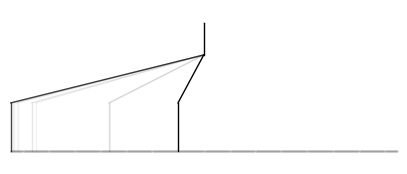

In [ ]:
# Assuming the model and grade are already defined and trained
model = model.prune(edge_th=1e-2)  # Prune the model by removing edges with small weights
print(f"Model pruned for grade {grade}")

# Plot the pruned model
model.plot()  # Visualize the pruned model
print(f"Model plot displayed for grade {grade}")

